In [1]:
import os
import pickle
from itertools import compress, chain
import numpy as np

import pandas as pd
from PIL import Image
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from scipy.stats import entropy, norm, uniform
from torchvision import datasets, transforms

from cleanlab.classification import CleanLearning
from cleanlab.filter import find_label_issues, find_predicted_neq_given, find_label_issues_using_argmax_confusion_matrix
from cleanlab.dataset import health_summary
from cleanlab.count import get_confident_thresholds
from cleanlab.rank import get_label_quality_scores, get_normalized_margin_for_each_label, get_self_confidence_for_each_label, get_confidence_weighted_entropy_for_each_label
from cleanlab.internal.label_quality_utils import (
    _subtract_confident_thresholds,
    get_normalized_entropy,
)

# from dataset_config import gtsrb as config
from dataset_config import swedish as config

from model import Net, GtsrbFolderWithPaths, SwedishFolderWithPaths
# from classes_name import gtsrb_classes as classes_name
from id_to_class import swedish_classes as classes_name

In [2]:
import os
import pickle
from itertools import compress, chain
import numpy as np

import pandas as pd
from PIL import Image
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from scipy.stats import entropy, norm, uniform
from torchvision import datasets, transforms

from cleanlab.classification import CleanLearning
from cleanlab.filter import find_label_issues, find_predicted_neq_given, find_label_issues_using_argmax_confusion_matrix
from cleanlab.dataset import health_summary
from cleanlab.count import get_confident_thresholds
from cleanlab.rank import get_label_quality_scores, get_normalized_margin_for_each_label, get_self_confidence_for_each_label, get_confidence_weighted_entropy_for_each_label
from cleanlab.internal.label_quality_utils import (
    _subtract_confident_thresholds,
    get_normalized_entropy,
)

# from dataset_config import gtsrb as config
from dataset_config import swedish as config

from model import Net, GtsrbFolderWithPaths, SwedishFolderWithPaths
# from classes_name import gtsrb_classes as classes_name
from id_to_class import swedish_classes as classes_name

In [3]:
data_transforms = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(config['mean'], config['std'])
    ])

def read_data(paths):
    data = []
    for img_path in paths:
        try:
          image = Image.open(img_path)
          image = image.resize((32,32))
          image = np.array(image)
          data.append(image)
        except Exception as e:
          print(e)
    return data

In [4]:
# total_arr = {
#         'probs': total_outputs,
#         'labels_gt': total_labels_gt,
#         'labels_pred': total_labels_pred,
#         'losses': total_losses,
#         'paths': total_paths,
#     }
# model_path = './arr_4fold_epo20.pkl'
# model_path = './arr_4fold_noisy1_epo20.pkl'

num_classes = config['num_classes']
parent_dir = config['parent_dir']
model_dir = config['model_dir']
pred_dir = config['pred_dir']
fig_dir = config['fig_dir']
df_dir = config['df_dir']
num_classes = config['num_classes']

k = 4
kfold_dir = f'{parent_dir}/{k}fold'
model_path = f'{pred_dir}/swe_epo60.pkl'
figname = os.path.basename(model_path).replace('.pkl', '')

with open(model_path, "rb") as f:
    total_arr = pickle.load(f)

probs = total_arr['probs']
pred_prob = np.max(probs, axis=1)
pred_prob_idx = np.argmax(probs, axis=1)
print(f'probs.shape={probs.shape}')
print(f'pred_prob_idx.shape={pred_prob_idx.shape}')
print(f'probs[0]={probs[0]}')
print(f'sum to 1 ={sum(probs[0])}')

labels_gt = total_arr['labels_gt']
labels_pred = total_arr['labels_pred']
losses = total_arr['losses']
paths = total_arr['paths']
imgnames = total_arr['filenames']
labels_gt_des = [classes_name[int(i)] for i in labels_gt]
labels_pred_des = [classes_name[int(i)] for i in labels_pred]
data_idxs = list(range(len(paths)))
data = read_data(paths)
print(f'len(data)={len(data)}')
print(f'len(paths)={len(paths)}')
# classes_id = list(range(num_classes))
# classes_des = [i for i in classes_name.values()]



df = pd.DataFrame(list(zip(pred_prob, labels_gt, labels_gt_des, labels_pred, labels_pred_des, losses, paths, imgnames, data_idxs)),
                  columns=['probs', 'labels_gt', 'labels_gt_des', 'labels_pred', 'labels_pred_des', 'losses', 'paths', 'imgnames', 'data_idxs'], index=data_idxs)
df.head(10)

probs.shape=(2503, 17)
pred_prob_idx.shape=(2503,)
probs[0]=[7.50212418e-03 7.67205656e-03 1.32955192e-02 4.42141145e-02
 3.82321631e-03 9.07000244e-01 5.96245751e-03 5.39460033e-03
 4.61079733e-04 9.12551404e-05 5.70046905e-05 3.65304877e-03
 6.07998663e-05 3.98999255e-05 2.60075787e-04 8.76178819e-05
 4.24880593e-04]
sum to 1 =0.9999999946448952
len(data)=2503
len(paths)=2503


probs  labels_gt labels_gt_des  labels_pred labels_pred_des    losses  \
0  0.907000          5       70_SIGN            5         70_SIGN -0.907000   
1  0.556580          5       70_SIGN            5         70_SIGN -0.556580   
2  0.984647          5       70_SIGN            5         70_SIGN -0.984647   
3  0.928527          5       70_SIGN            5         70_SIGN -0.928527   
4  0.976562          5       70_SIGN            5         70_SIGN -0.976562   
5  0.719691          5       70_SIGN            5         70_SIGN -0.719691   
6  0.641706          5       70_SIGN            5         70_SIGN -0.641706   
7  0.950667          5       70_SIGN            5         70_SIGN -0.950667   
8  0.891674          5       70_SIGN            5         70_SIGN -0.891674   
9  0.822011          5       70_SIGN            5         70_SIGN -0.822011   

                                               paths            imgnames  \
0  ../datasets/sweden-traffic-signs-classificatio...  picture-344570.jpg   
1  ../datasets/sweden-traffic-signs-classificatio...  picture-676969.jpg   
2  ../datasets/sweden-traffic-signs-classificatio...  picture-278343.jpg   
3  ../datasets/sweden-traffic-signs-classificatio...  picture-434551.jpg   
4  ../datasets/sweden-traffic-signs-classificatio...  picture-815787.jpg   
5  ../datasets/sweden-traffic-signs-classificatio...  picture-910395.jpg   
6  ../datasets/sweden-traffic-signs-classificatio...  picture-107451.jpg   
7  ../datasets/sweden-traffic-signs-classificatio...  picture-019176.jpg   
8  ../datasets/sweden-traffic-signs-classificatio...  picture-234061.jpg   
9  ../datasets/sweden-traffic-signs-classificatio...  picture-298319.jpg   

   data_idxs  
0          0  
1          1  
2          2  
3          3  
4          4  
5          5  
6          6  
7          7  
8          8  
9          9

In [5]:
print('--------------- Per-class confident threshold ---------------')
conf_thresholds = get_confident_thresholds(labels_gt, probs)
print(f'conf_thresholds={conf_thresholds}')

print('--------------- get_label_quality_scores ---------------')

label_quality_scores = get_label_quality_scores(labels_gt, probs)
print(f'label_quality_scores={label_quality_scores}')

print('--------------- get_normalized_margin_for_each_label ---------------')

normalized_margin_for_each_label = get_normalized_margin_for_each_label(labels_gt, probs)
print(f'normalized_margin_for_each_label={normalized_margin_for_each_label}')

print('--------------- get_self_confidence_for_each_label ---------------')

self_confidence_for_each_label = get_self_confidence_for_each_label(labels_gt, probs)
print(f'self_confidence_for_each_label={self_confidence_for_each_label}')

print('--------------- get_confidence_weighted_entropy_for_each_label( ---------------')

confidence_weighted_entropy_for_each_label = get_confidence_weighted_entropy_for_each_label(labels_gt, probs)
print(f'confidence_weighted_entropy_for_each_label={confidence_weighted_entropy_for_each_label}')

--------------- Per-class confident threshold ---------------
conf_thresholds=[0.61715942 0.05158655 0.1193011  0.53928452 0.07819848 0.83077006
 0.32819278 0.0467487  0.95037658 0.70351909 0.75584412 0.80814795
 0.67403304 0.96708643 0.96970919 0.98386878 0.78994859]
--------------- get_label_quality_scores ---------------


2023-02-24 10:41:45.076866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 10:41:45.552639: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.3/lib64
2023-02-24 10:41:45.552697: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.3/lib64
2023-02-24 10:41:45.552702: W tensorflow/compiler/tf2tensorrt/utils/py_uti

label_quality_scores=[0.90700024 0.55657989 0.98464727 ... 0.83877152 0.97653496 0.99439055]
--------------- get_normalized_margin_for_each_label ---------------
normalized_margin_for_each_label=[0.93139306 0.68076205 0.98863421 ... 0.85314333 0.97920267 0.99655225]
--------------- get_self_confidence_for_each_label ---------------
self_confidence_for_each_label=[0.90700024 0.55657989 0.98464727 ... 0.83877152 0.97653496 0.99439055]
--------------- get_confidence_weighted_entropy_for_each_label( ---------------
confidence_weighted_entropy_for_each_label=[0.91826657 0.70052705 0.9815695  ... 0.89759917 0.97652541 0.99176773]


In [6]:
# # losses[33514]
# # a = df.loc[df['imgnames']=='00035_00009_00026.png']
# # a_path = a['paths'].tolist()
# # data = read_data(a_path)[0]
# # plt.imshow(data)
# # pd.describe_option('display')
# a = df[df['imgnames'].str.contains("00010_99000_")]
# # df['imgnames'].filter(regex='00010_99000_[*]', axis=0)
# a['imgnames'].size
# a

In [7]:
df_sorted = df.sort_values(by=['losses'], ascending=False)
df_sorted.head(50)

# losses[33514]
# aa = df_sorted.loc[df['imgnames']=='picture-759037.jpg']
# aa_path = aa['paths'].tolist()
# aa_data = read_data(aa_path)[0]
# plt.imshow(aa_data)
# plt.clf()
# plt.cla()
# plt.close()

probs  labels_gt        labels_gt_des  labels_pred  labels_pred_des  \
916   0.998867          0             100_SIGN           15    PRIORITY_ROAD   
21    0.997117          5              70_SIGN           15    PRIORITY_ROAD   
31    0.997111          5              70_SIGN           15    PRIORITY_ROAD   
592   0.984032         11                OTHER            8         GIVE_WAY   
2378  0.677629          8             GIVE_WAY           11            OTHER   
1595  0.837451          3              50_SIGN           11            OTHER   
506   0.843133          2              30_SIGN            8         GIVE_WAY   
644   0.495999          5              70_SIGN           15    PRIORITY_ROAD   
331   0.888992          3              50_SIGN            8         GIVE_WAY   
2159  0.623874         14  PEDESTRIAN_CROSSING           13  PASS_RIGHT_SIDE   
2418  0.341900          1             110_SIGN           11            OTHER   
1136  0.720108          7              90_SIGN            5          70_SIGN   
312   0.612178          6              80_SIGN            8         GIVE_WAY   
534   0.552506         16                 STOP           11            OTHER   
1173  0.964133         11                OTHER           15    PRIORITY_ROAD   
2315  0.428132         15        PRIORITY_ROAD           11            OTHER   
507   0.763166          2              30_SIGN            5          70_SIGN   
539   0.339674          1             110_SIGN            3          50_SIGN   
509   0.466019          7              90_SIGN            3          50_SIGN   
1164  0.402743          1             110_SIGN            0         100_SIGN   
715   0.528223         13      PASS_RIGHT_SIDE           11            OTHER   
1232  0.573178         11                OTHER            8         GIVE_WAY   
763   0.922165         14  PEDESTRIAN_CROSSING           13  PASS_RIGHT_SIDE   
1137  0.655519          7              90_SIGN            5          70_SIGN   
2382  0.760546          2              30_SIGN            5          70_SIGN   
1130  0.685716          2              30_SIGN            5          70_SIGN   
316   0.343855          6              80_SIGN           11            OTHER   
966   0.402686          3              50_SIGN           11            OTHER   
2393  0.342261          7              90_SIGN            3          50_SIGN   
2158  0.914918         14  PEDESTRIAN_CROSSING           11            OTHER   
512   0.386784          7              90_SIGN            3          50_SIGN   
540   0.356114          4              60_SIGN            3          50_SIGN   
800   0.640814         14  PEDESTRIAN_CROSSING           11            OTHER   
1163  0.370772          1             110_SIGN            5          70_SIGN   
537   0.386003          1             110_SIGN            5          70_SIGN   
2415  0.533214          1             110_SIGN            5          70_SIGN   
535   0.519677          1             110_SIGN            5          70_SIGN   
504   0.407688          2              30_SIGN            3          50_SIGN   
1793  0.457417          4              60_SIGN            8         GIVE_WAY   
538   0.401886          1             110_SIGN            5          70_SIGN   
2392  0.341405          7              90_SIGN            5          70_SIGN   
863   0.953201         14  PEDESTRIAN_CROSSING           11            OTHER   
2419  0.336052          4              60_SIGN            8         GIVE_WAY   
2189  0.318520          6              80_SIGN            3          50_SIGN   
1134  0.686208          2              30_SIGN            5          70_SIGN   
1763  0.383010          7              90_SIGN            5          70_SIGN   
2388  0.705730          2              30_SIGN            5          70_SIGN   
1765  0.451397          7              90_SIGN            5          70_SIGN   
1557  0.441810          6              80_SIGN            5          70_SIGN   
536   0.2

In [8]:
def plot_examples(figpath, main_title, X, labels_gt, id_iter, nrows, ncols, labels_pred, losses, imgnames, labels_gt_des, labels_pred_des, probs, show_img=True):
#     print(f'id_iter={id_iter}')
#     plt.figure()
    dpi = 300
    fig = plt.figure(dpi=dpi, figsize=(18,15))
    
    for count, id in enumerate(id_iter):
#         print(f'id={id}, count={count}')
#         print(f'imgnames={imgnames[id]}')
# #         print(f'imgnames={imgnames[id]}')
#         print(f'labels_gt={labels_gt[id]}')
#         print(f'labels_pred={labels_pred[id]}')
#         print(f'labels_pred_des={labels_pred_des[id]}')
        
        title = f"{imgnames[id]}\ngt({labels_gt[id]}): {labels_gt_des[id]}\npred({labels_pred[id]}): {labels_pred_des[id]}\nprob: {probs[id]:.3f}\nloss: {losses[id]:.7f}"
        ax = fig.add_subplot(nrows, ncols, count + 1)
        ax.set_title(title, fontdict={'fontsize': 8, 'fontweight': 4})
        plt.imshow(X[id], cmap="gray")
        #         plt.title(title, fontdict={'fontsize': 4, 'fontweight': 4})
        plt.axis("off")
        # plt.subplots_adjust(wspace=0.4, hspace=0.4, left=0.1, bottom=1, right=0.95, top=3.5)
#         print('----')
    plt.tight_layout()
    # print(f'# of pyplot figure stack: {plt.get_fignums()}')
    plt.suptitle(main_title)
    plt.savefig(figpath, dpi=dpi, bbox_inches='tight')

    print(f'show_img={show_img} {type(show_img)}')
    if show_img:
        plt.show()
    # print(f'# of pyplot figure stack: {plt.get_fignums()}')
    

show_img=False <class 'bool'>


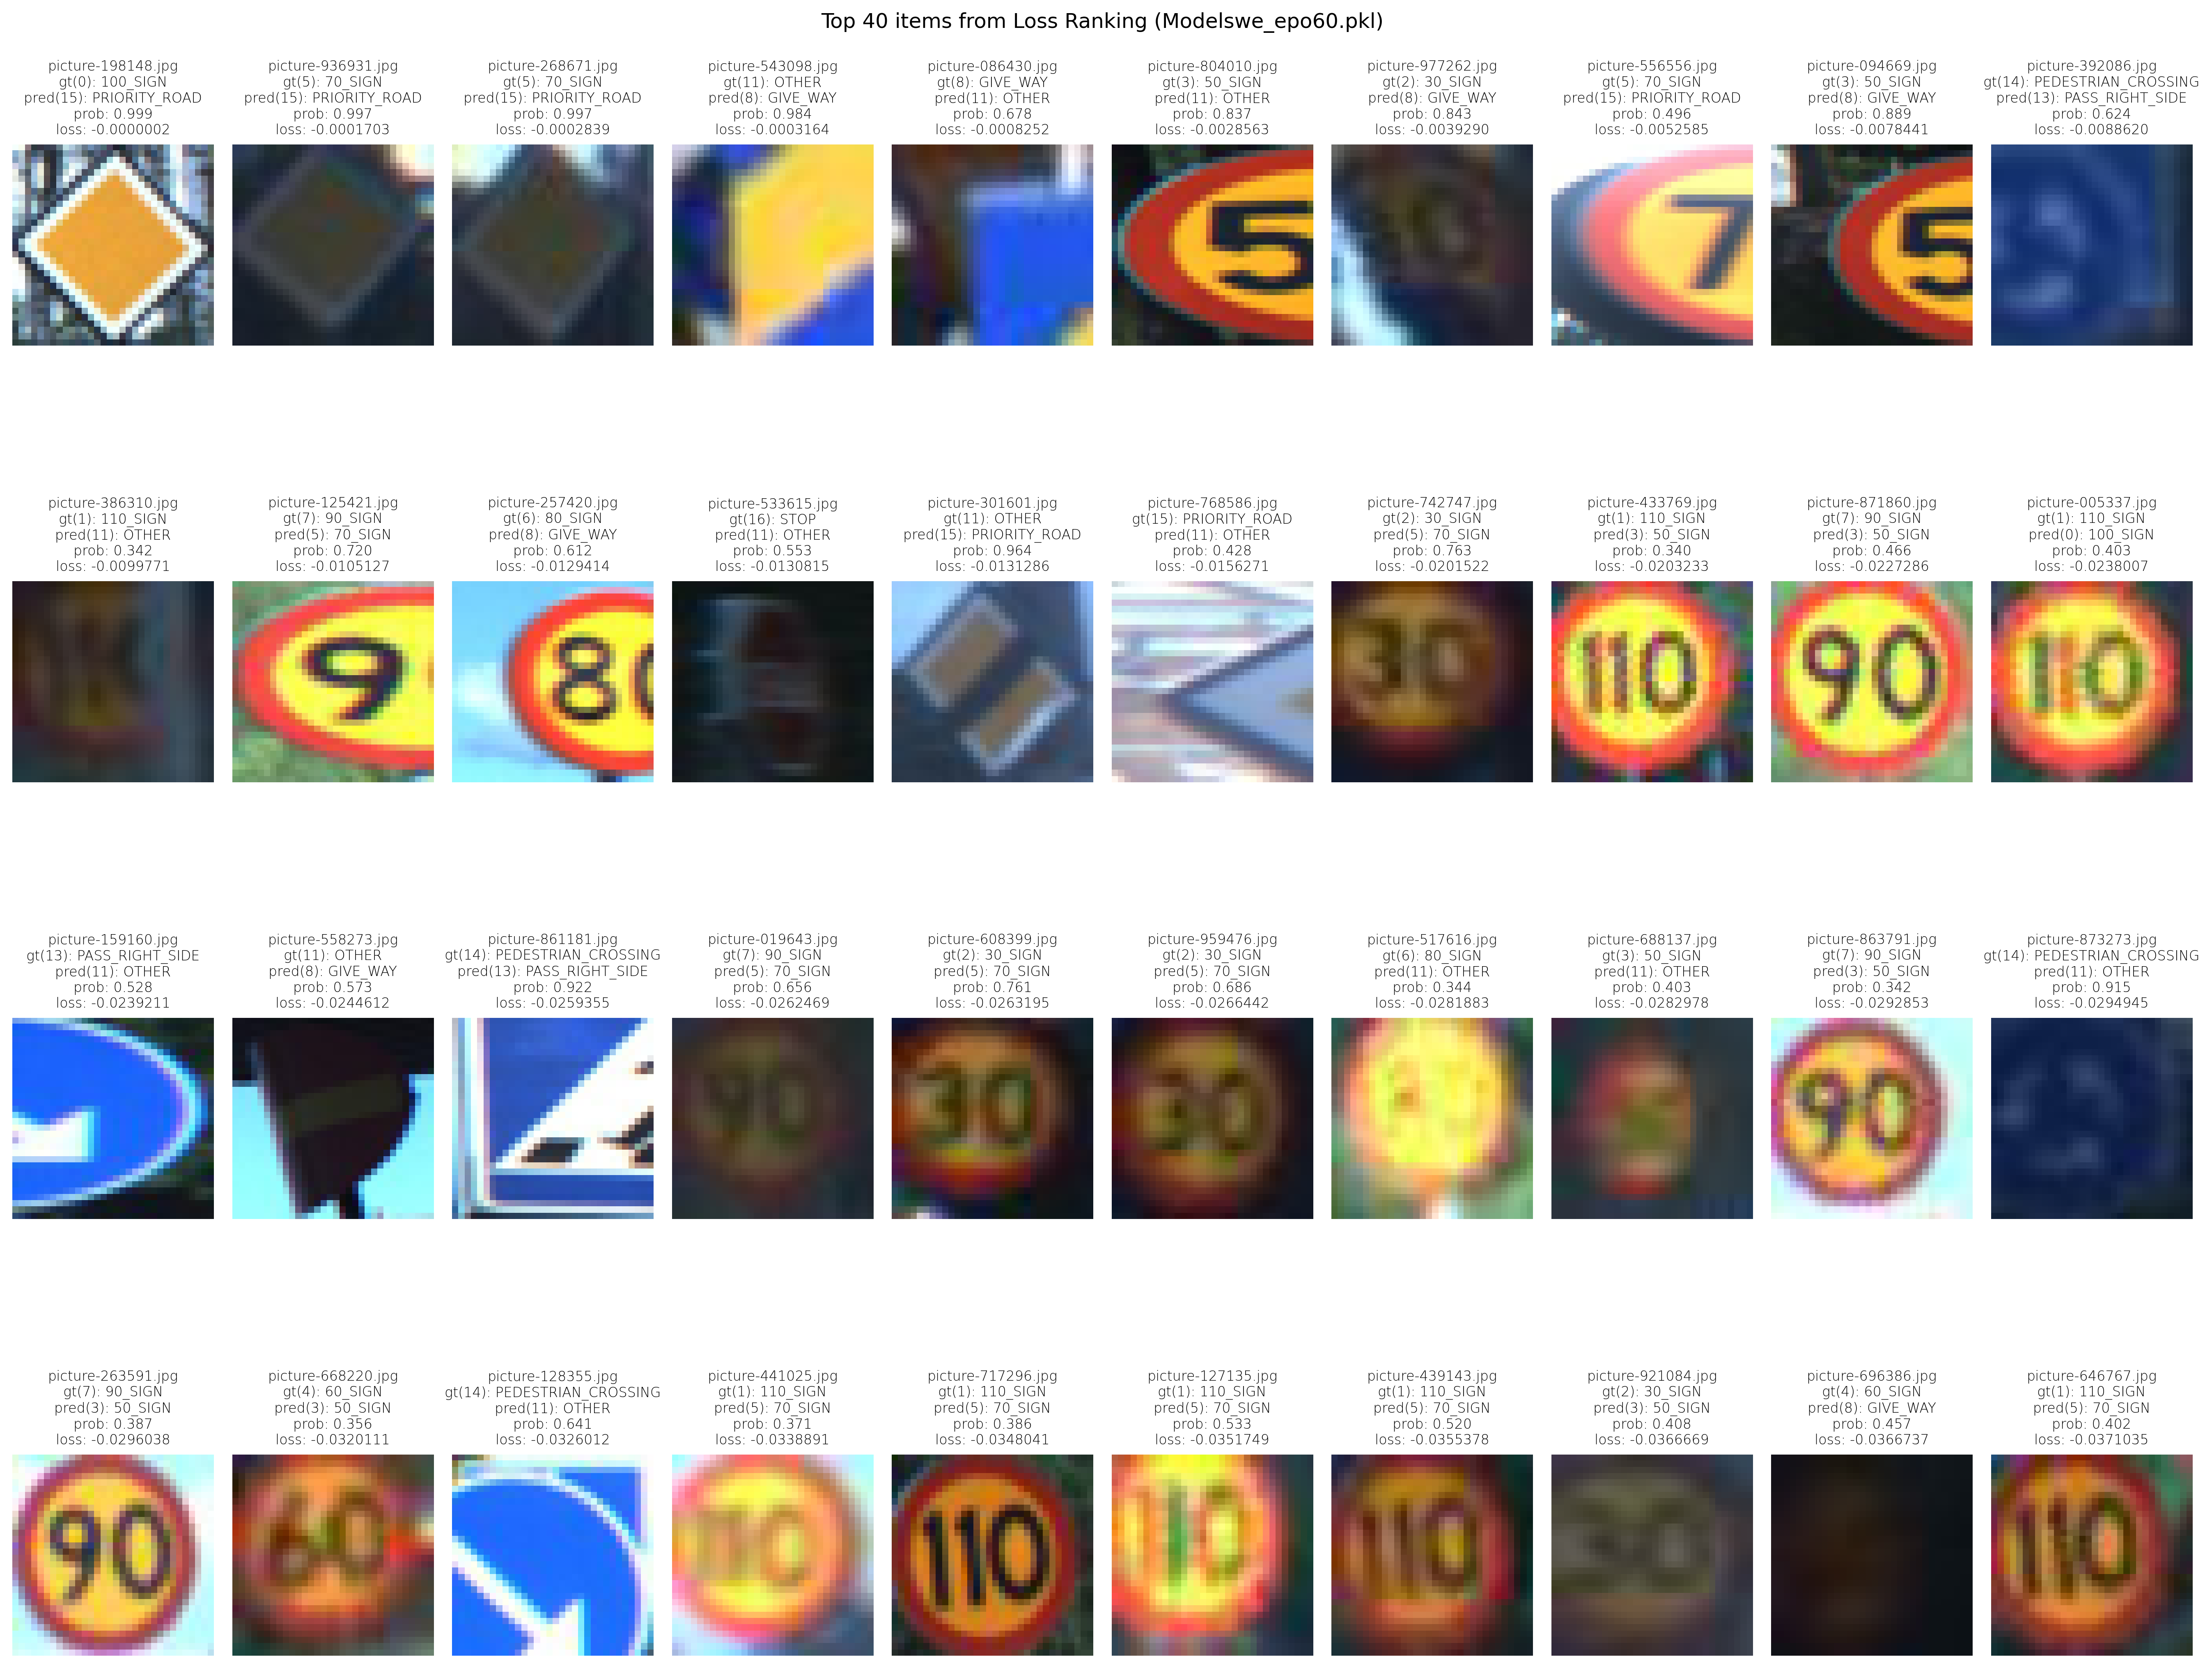

In [9]:
rank_nums = 40
lrank_losses = df_sorted['losses'].iloc[:rank_nums].tolist()
lrank_paths = df_sorted['paths'].iloc[:rank_nums].tolist()
lrank_labels_pred = df_sorted['labels_pred'].iloc[:rank_nums].tolist()
lrank_labels_gt = df_sorted['labels_gt'].iloc[:rank_nums].tolist()
lrank_imgnames = df_sorted['imgnames'].iloc[:rank_nums].tolist()
lrank_labels_gt_des = df_sorted['labels_gt_des'].iloc[:rank_nums].tolist()
lrank_labels_pred_des = df_sorted['labels_pred_des'].iloc[:rank_nums].tolist()
lrank_probs = df_sorted['probs'].iloc[:rank_nums].tolist()
lrank_data = read_data(lrank_paths)
lrank_main_title = f'Top {rank_nums} items from Loss Ranking (Model{figname}.pkl)'
lrank_figpath = f'{fig_dir}/{figname}_LRank.png'


plot_examples(lrank_figpath, lrank_main_title, lrank_data, lrank_labels_gt, list(range(rank_nums)), 4, 10, lrank_labels_pred, lrank_losses, lrank_imgnames, lrank_labels_gt_des, lrank_labels_pred_des, lrank_probs, False)

In [10]:
print(f'{probs.shape}')
print(f'{len(labels_gt)}')
print(f'{len(labels_pred)}')

(2503, 17)
2503
2503


Cleanlab found 86 label issues.
Top 15 most likely label errors:
[ 916   21   31  592 1173  863 2158  331 1595  507 2382  219 1136 1134
 1137]
show_img=False <class 'bool'>
Cleanlab found 86 label issues.
Top 15 most likely label errors:
[ 916   21   31  592 1595  644  331 2418 1136  312 1173  507  539  509
 1232]
show_img=False <class 'bool'>
Cleanlab found 86 label issues.
Top 15 most likely label errors:
[ 916  592 1595  644 2418   21  312 1136   31  539  331  509  316  966
  540]
show_img=False <class 'bool'>


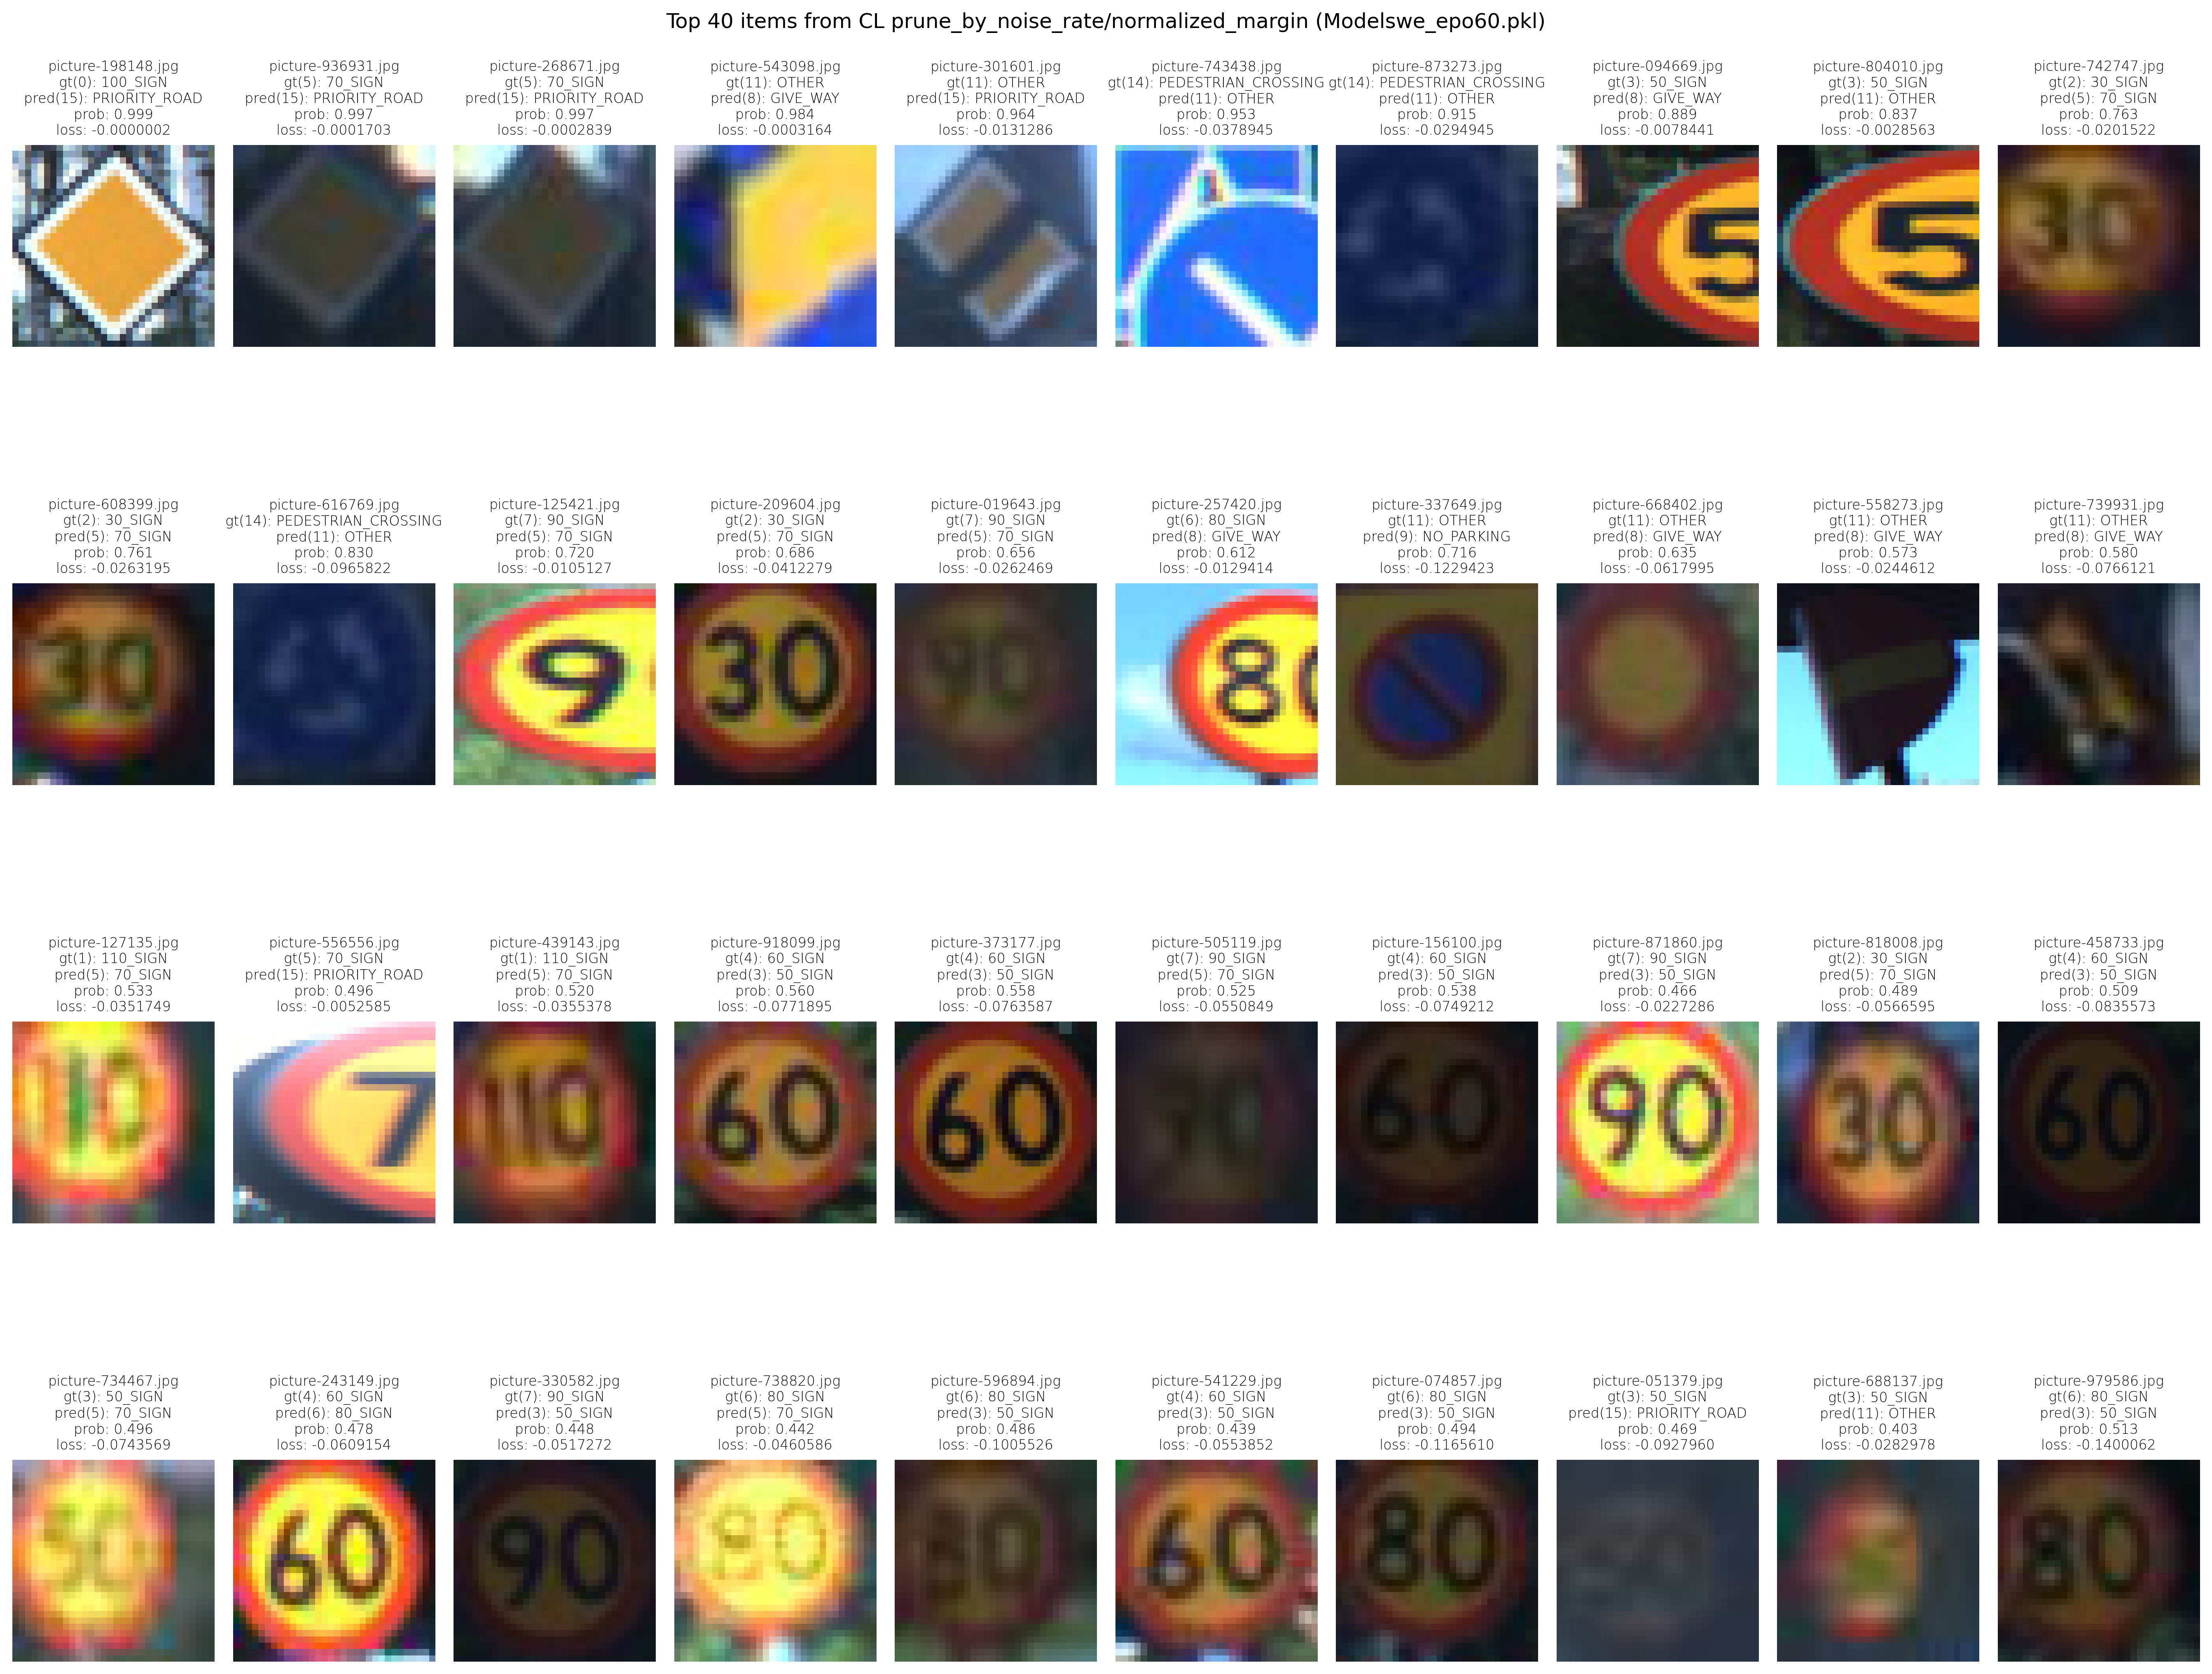

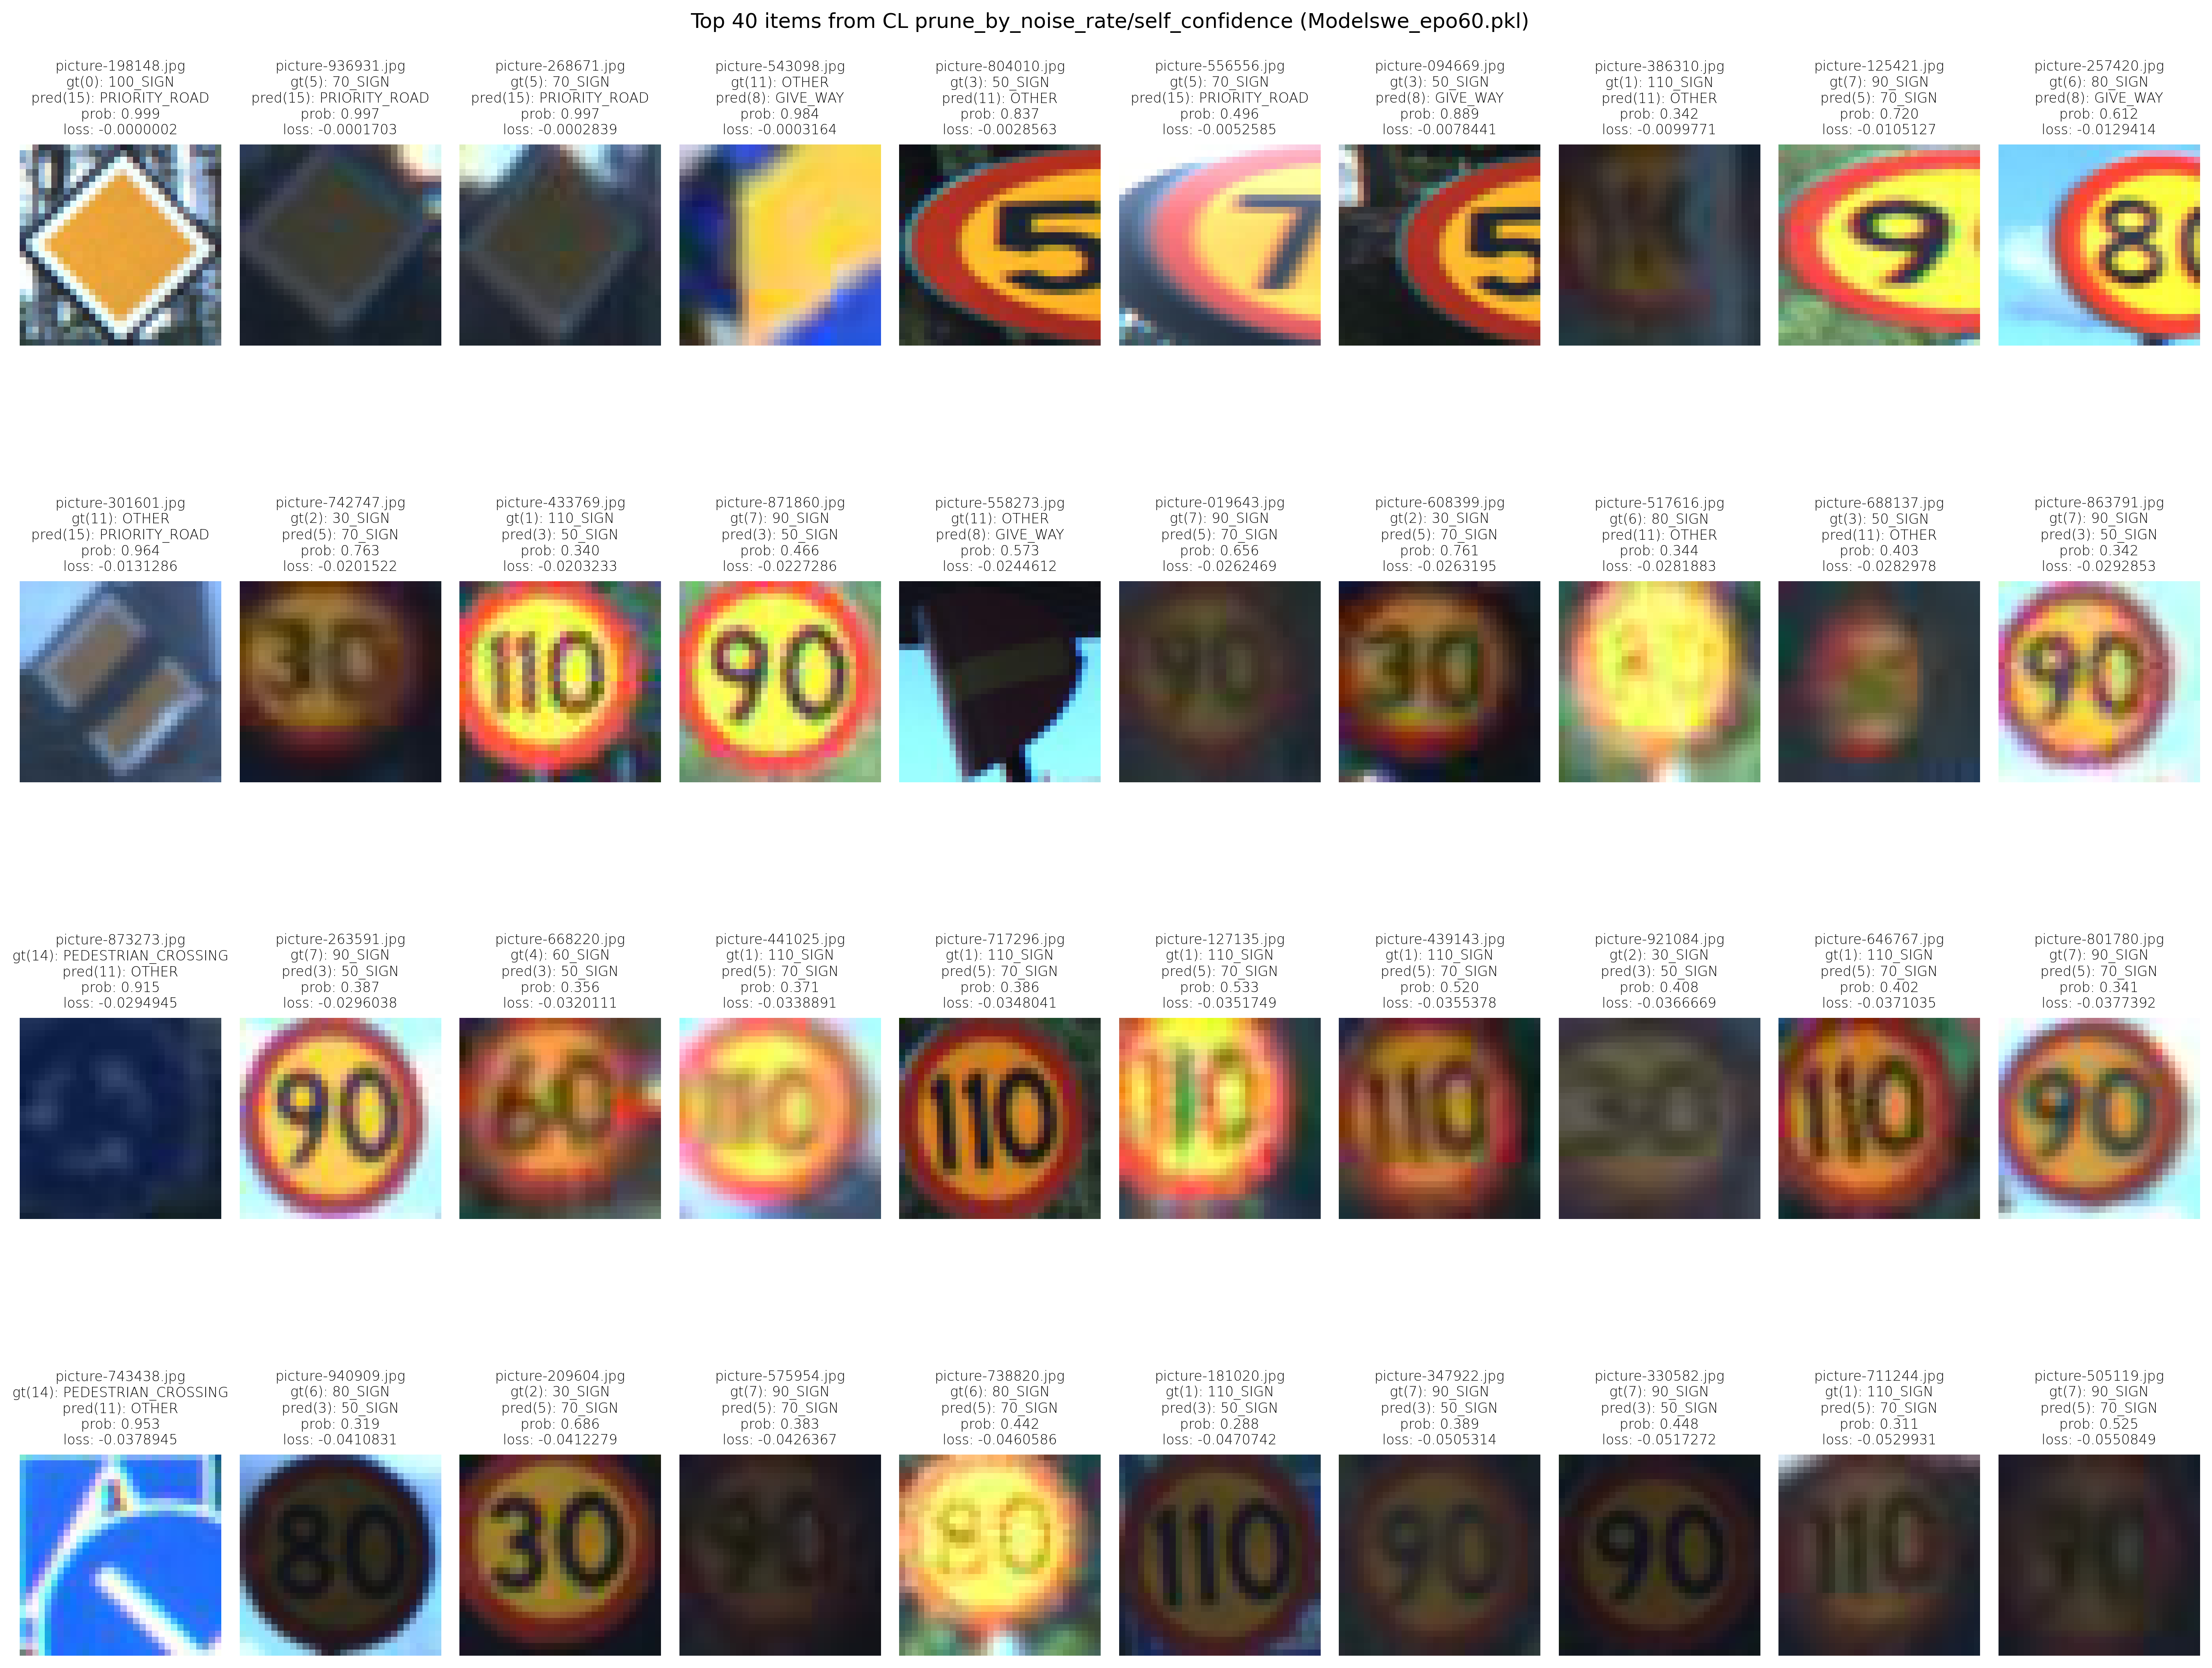

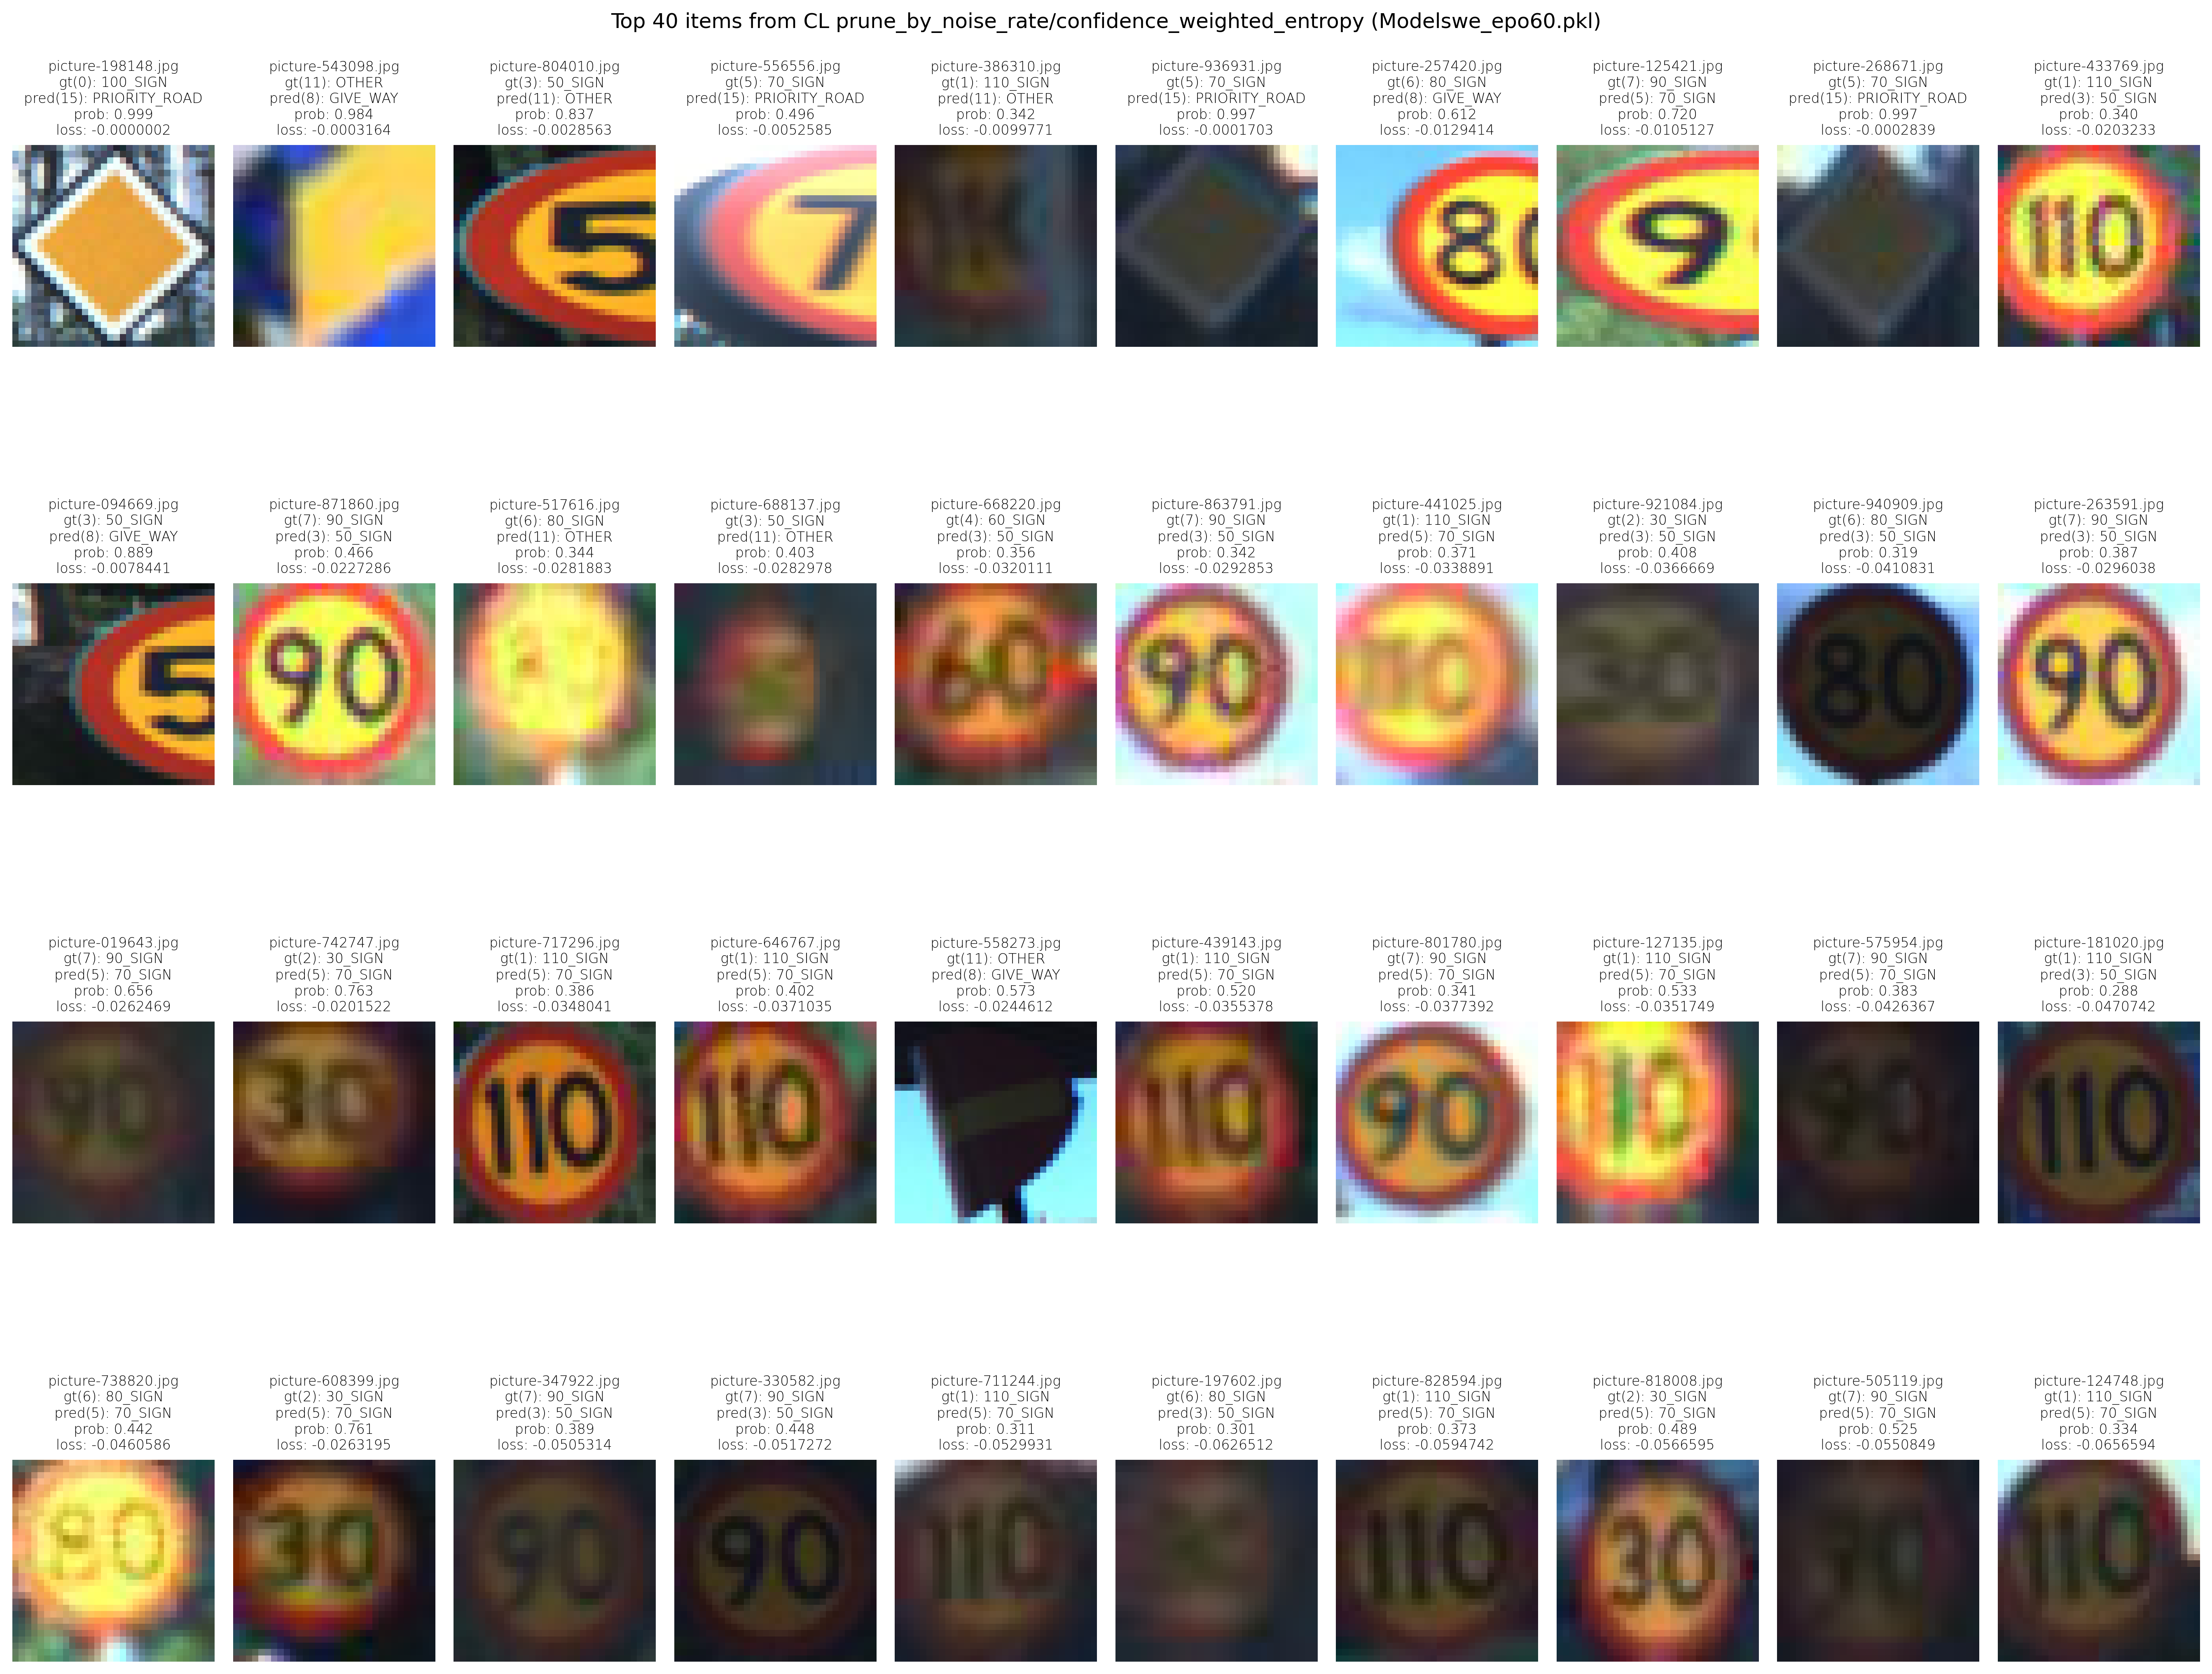

In [11]:

def CL_find_label_issues(filter_by, ranked_by):

    ranked_label_issues = find_label_issues(
        labels_gt,
        probs,
        filter_by=filter_by,
        return_indices_ranked_by=ranked_by,
    )

    return ranked_label_issues

ranked_by_options = ['normalized_margin', 'self_confidence', 'confidence_weighted_entropy']
filter_by_options = ['prune_by_class', 'prune_by_noise_rate', 'both', 'confident_learning', 'predicted_neq_given']
# https://docs.cleanlab.ai/v2.0.0/cleanlab/filter.html?highlight=predicted_neq_given#cleanlab.filter.find_label_issues
shorten = {
    'normalized_margin': 'NMargin',
    'self_confidence': 'SConf',
    'confidence_weighted_entropy': 'CWE',
    'prune_by_class': 'PBC',
    'prune_by_noise_rate': 'PBNR',
    'both': 'Both',
    'confident_learning': 'CL',
    'predicted_neq_given':  'ArgMax',
    'Loss_Ranking': 'LRank'
}

comb = {}
CL_label_issues ={}

for filter_by in filter_by_options:
    comb[filter_by] = [(filter_by, rank_by) for rank_by in ranked_by_options]


opts = comb['prune_by_noise_rate']


rank_nums = 40
for filter_opt, rank_opt in opts:
    ranked_label_issues = CL_find_label_issues(filter_opt, rank_opt)
    CL_label_issues[(filter_opt, rank_opt)] = ranked_label_issues.tolist()
    print(f"Cleanlab found {len(ranked_label_issues)} label issues.")
    print(f"Top 15 most likely label errors:\n{ranked_label_issues[:15]}")

    assert len(ranked_label_issues) > rank_nums

    CL_main_title = f'Top {rank_nums} items from CL {filter_opt}/{rank_opt} (Model{figname}.pkl)'

    CL_figpath = f'{fig_dir}/{figname}_CL_{shorten[filter_opt]}_{shorten[rank_opt]}.png'
    plot_examples(CL_figpath, CL_main_title, data, labels_gt, ranked_label_issues[range(rank_nums)], 4, 10, labels_pred, losses, imgnames, labels_gt_des, labels_pred_des, pred_prob, False)
    

In [12]:
def compare_idxes(compare_list):
    # print(f'compare_list={compare_list}')
    dup_idxes = set.intersection(*[set(list) for list in compare_list])
    diff_idxes = set.difference(*[set(list) for list in compare_list])
    print(f'Number of total duplicated = {len(dup_idxes)}')
    print(f'Number of total unique = {len(diff_idxes)}')

    assert len(diff_idxes.intersection(dup_idxes)) == 0

    return dup_idxes, diff_idxes

# compare_list = list(label_issues.values())
# dup_idxes = set.intersection(*[set(list) for list in compare_list])
# print(f'Number of total duplicated for CL only = {len(dup_idxes)}')
print('Compare CL label issues without Loss Ranking')
compare_list = list(CL_label_issues.values())
CL_dup_idxes, CL_diff_idxes = compare_idxes(compare_list)

Compare CL label issues without Loss Ranking
Number of total duplicated = 86
Number of total unique = 0


In [13]:
rank_nums = 86
lrank_label_issues = {}
print(f'Filter out loss ranking base on # of label isses CL={rank_nums}')
lrank_label_issues[('Loss_Ranking')] = df_sorted['data_idxs'][:rank_nums].tolist()
# print(f'label_issues=\n{label_issues}')

all_compare_list = [lrank_label_issues[('Loss_Ranking')], *list(CL_label_issues.values())]

print(f'len of all_compare_list={len(all_compare_list)}')

print('Compare CL label issues with Loss Ranking')
all_dup_idxes, all_diff_idxes = compare_idxes(all_compare_list)

# print('Compare CL normalized_margin label issues with Loss Ranking')
# compare_list1 = [lrank_label_issues[('Loss_Ranking')], CL_label_issues[('prune_by_noise_rate', 'normalized_margin')]]
# _, _ = compare_idxes(compare_list1)

Filter out loss ranking base on # of label isses CL=86
len of all_compare_list=4
Compare CL label issues with Loss Ranking
Number of total duplicated = 59
Number of total unique = 27


In [14]:
# ranked_by_options = ['normalized_margin', 'self_confidence', 'confidence_weighted_entropy']
# filter_by_options = ['prune_by_class', 'prune_by_noise_rate', 'both', 'confident_learning', 'predicted_neq_given']
# shorten = {
#     'normalized_margin': 'NMargin',
#     'self_confidence': 'SConf',
#     'confidence_weighted_entropy': 'CWE',
#     'prune_by_class': 'PBC',
#     'prune_by_noise_rate': 'PBNR',
#     'both': 'Both',
#     'confident_learning': 'CL',
#     'predicted_neq_given':  'ArgMax'
# }

num_rows = len(df_sorted)

for k, issue_indexes in CL_label_issues.items():

    filter_by = shorten[k[0]]
    ranked_by = shorten[k[1]]

    bool_list = [True if i in issue_indexes else False for i in df_sorted.index]
    # print(bool_list)
    # print('--------------------')
    df_sorted[f'{filter_by}_{ranked_by}'] = bool_list


for k, issue_indexes in lrank_label_issues.items():
    lossrank = shorten[k]

    bool_list = [True if i in issue_indexes else False for i in df_sorted.index]

    df_sorted[f'{lossrank}'] = bool_list



In [15]:
df_sorted.head(10)

probs  labels_gt        labels_gt_des  labels_pred  labels_pred_des  \
916   0.998867          0             100_SIGN           15    PRIORITY_ROAD   
21    0.997117          5              70_SIGN           15    PRIORITY_ROAD   
31    0.997111          5              70_SIGN           15    PRIORITY_ROAD   
592   0.984032         11                OTHER            8         GIVE_WAY   
2378  0.677629          8             GIVE_WAY           11            OTHER   
1595  0.837451          3              50_SIGN           11            OTHER   
506   0.843133          2              30_SIGN            8         GIVE_WAY   
644   0.495999          5              70_SIGN           15    PRIORITY_ROAD   
331   0.888992          3              50_SIGN            8         GIVE_WAY   
2159  0.623874         14  PEDESTRIAN_CROSSING           13  PASS_RIGHT_SIDE   

            losses                                              paths  \
916  -1.894439e-07  ../datasets/sweden-traffic-signs-classificatio...   
21   -1.703039e-04  ../datasets/sweden-traffic-signs-classificatio...   
31   -2.838651e-04  ../datasets/sweden-traffic-signs-classificatio...   
592  -3.164462e-04  ../datasets/sweden-traffic-signs-classificatio...   
2378 -8.252159e-04  ../datasets/sweden-traffic-signs-classificatio...   
1595 -2.856319e-03  ../datasets/sweden-traffic-signs-classificatio...   
506  -3.928970e-03  ../datasets/sweden-traffic-signs-classificatio...   
644  -5.258515e-03  ../datasets/sweden-traffic-signs-classificatio...   
331  -7.844064e-03  ../datasets/sweden-traffic-signs-classificatio...   
2159 -8.861963e-03  ../datasets/sweden-traffic-signs-classificatio...   

                imgnames  data_idxs  PBNR_NMargin  PBNR_SConf  PBNR_CWE  LRank  
916   picture-198148.jpg        916          True        True      True   True  
21    picture-936931.jpg         21          True        True      True   True  
31    picture-268671.jpg         31          True        True      True   True  
592   picture-543098.jpg        592          True        True      True   True  
2378  picture-086430.jpg       2378         False       False     False   True  
1595  picture-804010.jpg       1595          True        True      True   True  
506   picture-977262.jpg        506         False       False     False   True  
644   picture-556556.jpg        644          True        True      True   True  
331   picture-094669.jpg        331          True        True      True   True  
2159  picture-392086.jpg       2159         False       False     False   True

In [23]:
df_path = f'{df_dir}/{figname}'
df_sorted.to_csv(f'{df_path}.csv')

len of all_indexes=113, len of CL_indexes=86, lrank_indexes=86
Original len of rows =2503
filtered df len of rows =113
picture-198148.jpg gt=100_SIGN, pred=PRIORITY_ROAD


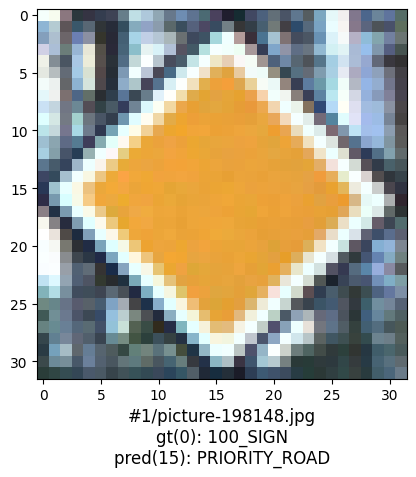

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=41
picture-936931.jpg gt=70_SIGN, pred=PRIORITY_ROAD


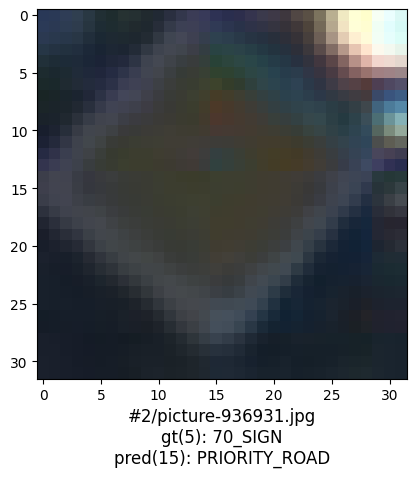

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=41
picture-268671.jpg gt=70_SIGN, pred=PRIORITY_ROAD


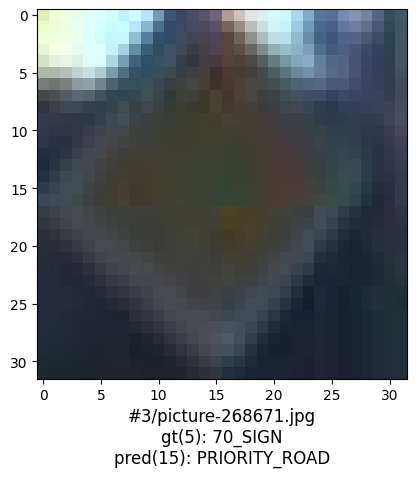

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=41
picture-543098.jpg gt=OTHER, pred=GIVE_WAY


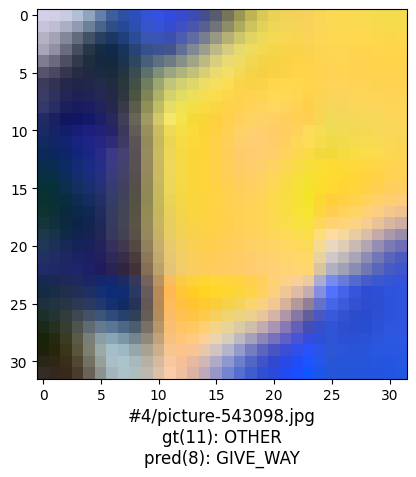

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=44
picture-086430.jpg gt=GIVE_WAY, pred=OTHER


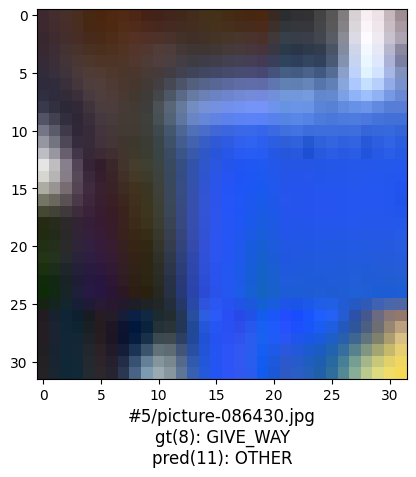

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-804010.jpg gt=50_SIGN, pred=OTHER


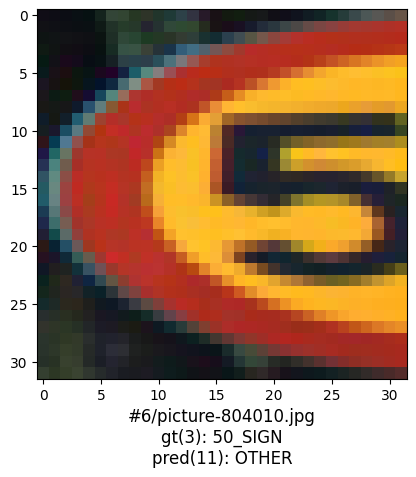

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-977262.jpg gt=30_SIGN, pred=GIVE_WAY


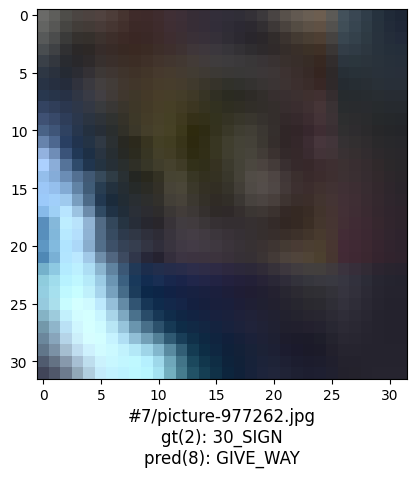

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=44
picture-556556.jpg gt=70_SIGN, pred=PRIORITY_ROAD


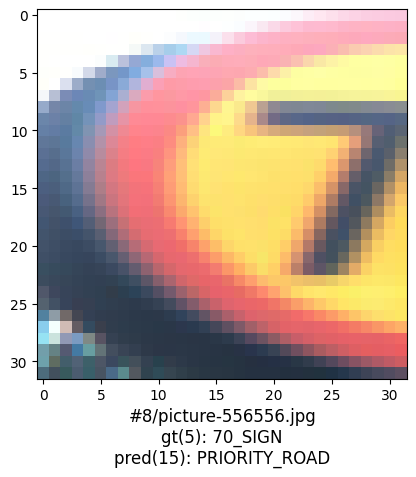

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-094669.jpg gt=50_SIGN, pred=GIVE_WAY


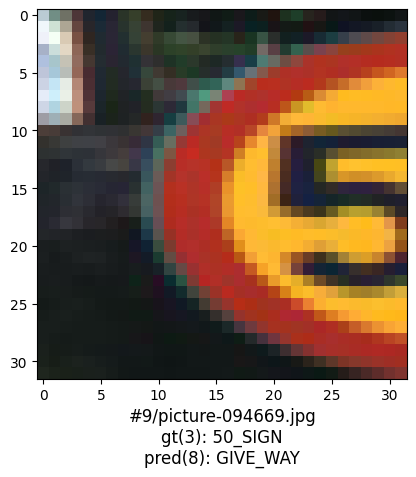

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-392086.jpg gt=PEDESTRIAN_CROSSING, pred=PASS_RIGHT_SIDE


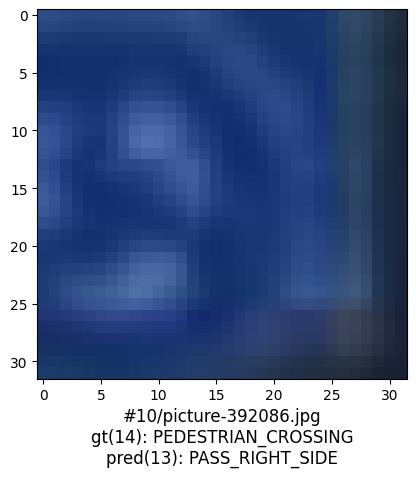

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=41
picture-386310.jpg gt=110_SIGN, pred=OTHER


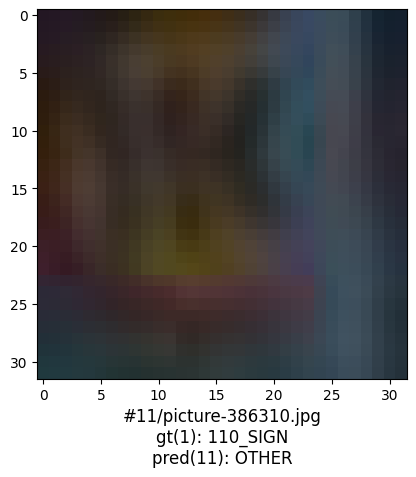

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-125421.jpg gt=90_SIGN, pred=70_SIGN


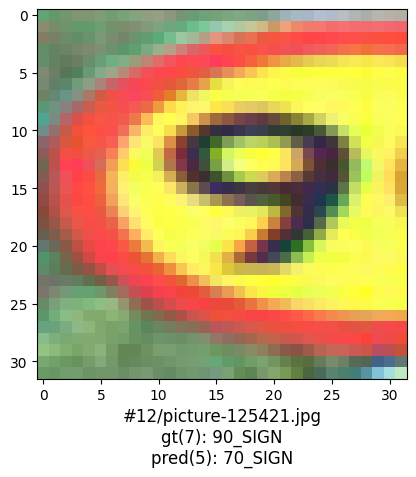

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-257420.jpg gt=80_SIGN, pred=GIVE_WAY


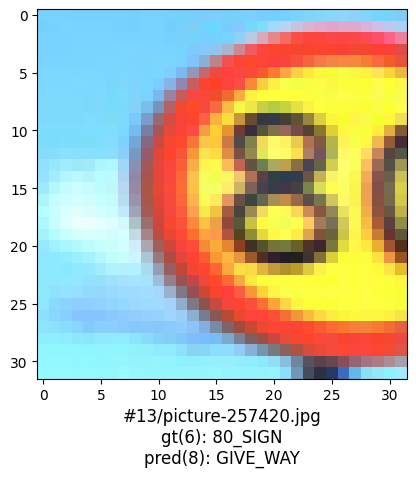

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-533615.jpg gt=STOP, pred=OTHER


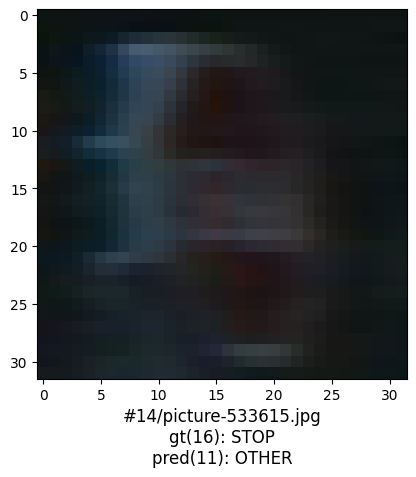

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-301601.jpg gt=OTHER, pred=PRIORITY_ROAD


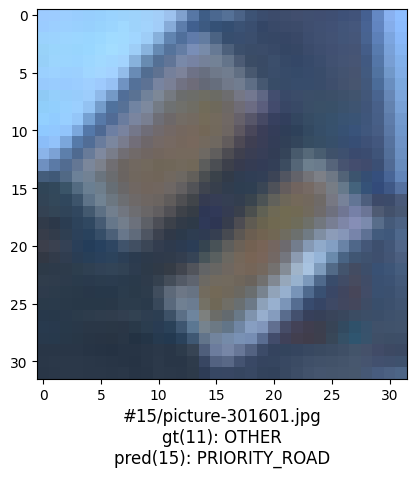

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=41
picture-768586.jpg gt=PRIORITY_ROAD, pred=OTHER


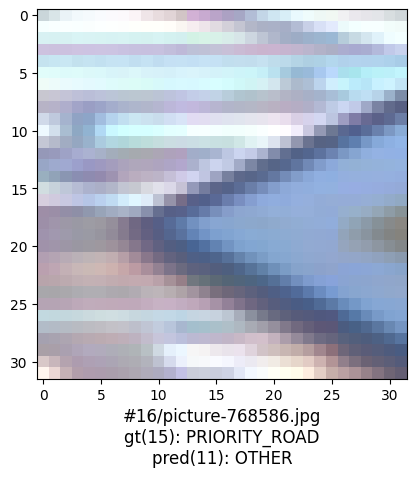

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-742747.jpg gt=30_SIGN, pred=70_SIGN


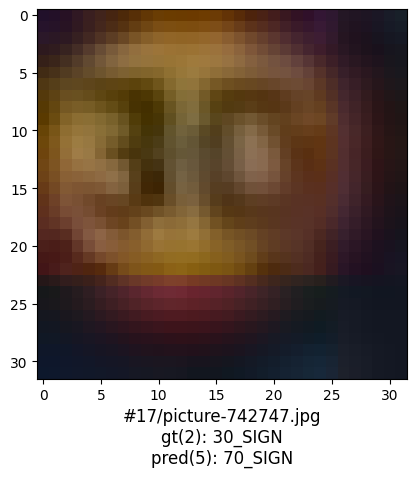

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-433769.jpg gt=110_SIGN, pred=50_SIGN


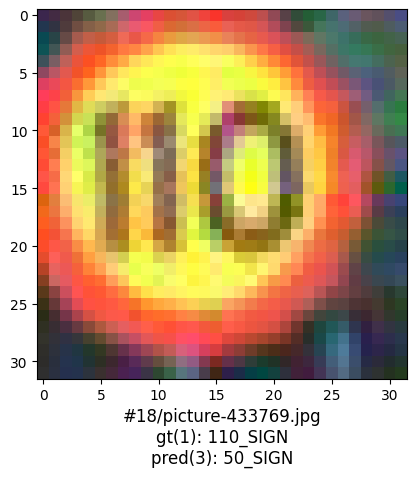

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-871860.jpg gt=90_SIGN, pred=50_SIGN


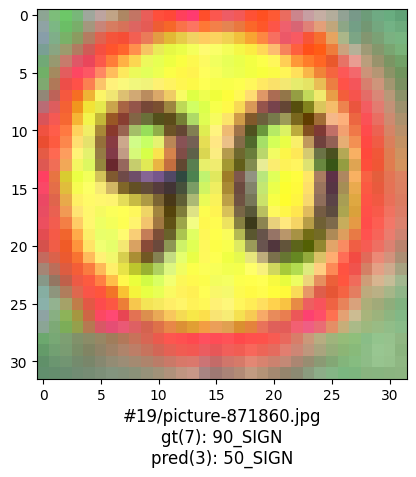

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-005337.jpg gt=110_SIGN, pred=100_SIGN


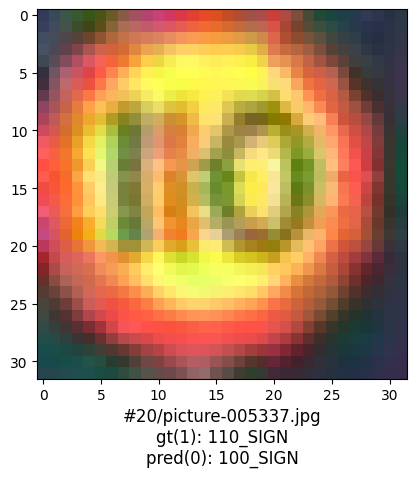

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-159160.jpg gt=PASS_RIGHT_SIDE, pred=OTHER


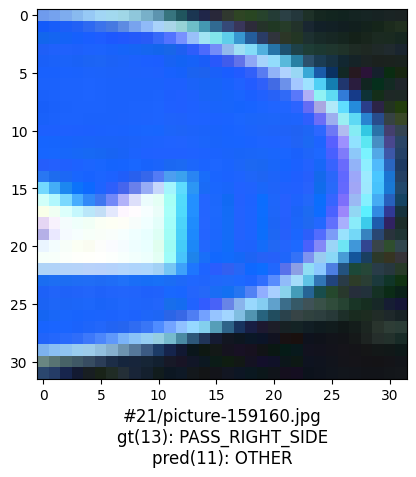

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-558273.jpg gt=OTHER, pred=GIVE_WAY


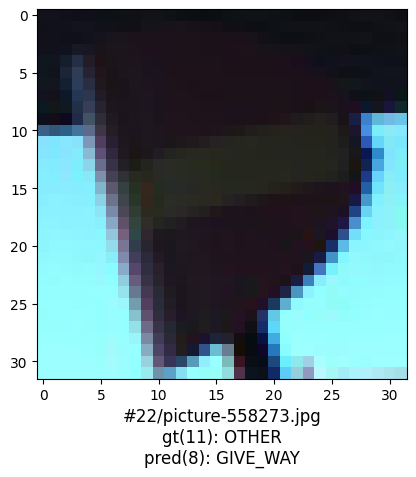

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-861181.jpg gt=PEDESTRIAN_CROSSING, pred=PASS_RIGHT_SIDE


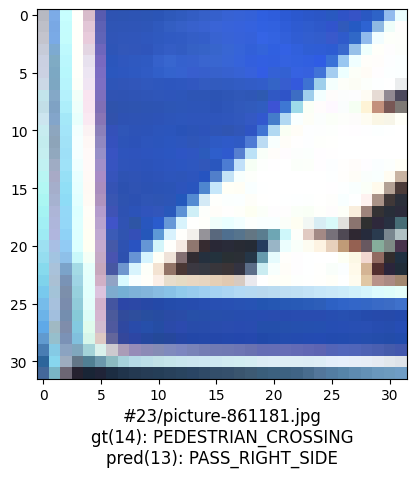

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-019643.jpg gt=90_SIGN, pred=70_SIGN


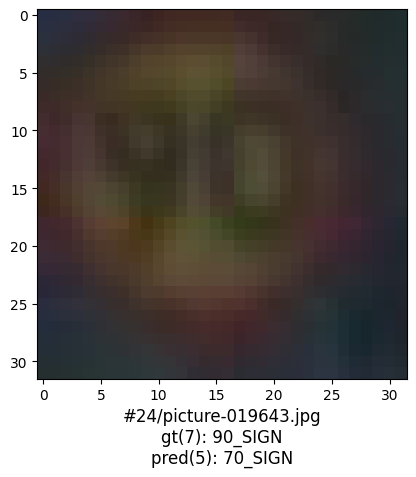

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-608399.jpg gt=30_SIGN, pred=70_SIGN


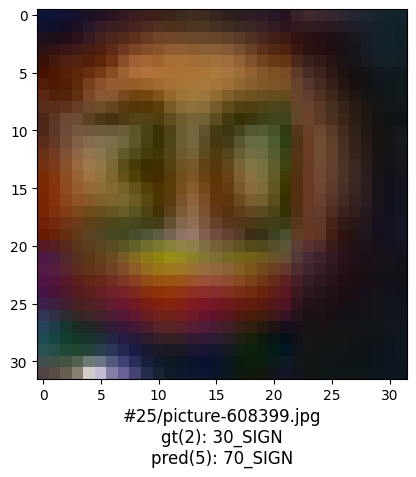

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-959476.jpg gt=30_SIGN, pred=70_SIGN


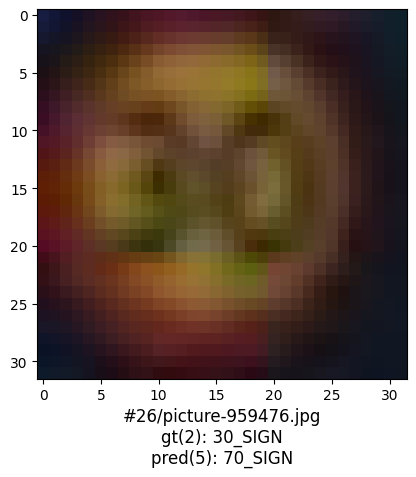

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-517616.jpg gt=80_SIGN, pred=OTHER


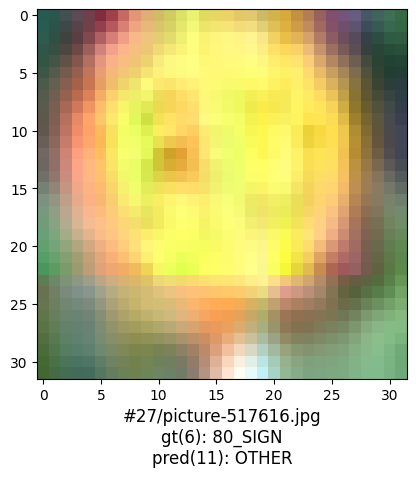

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=44
picture-688137.jpg gt=50_SIGN, pred=OTHER


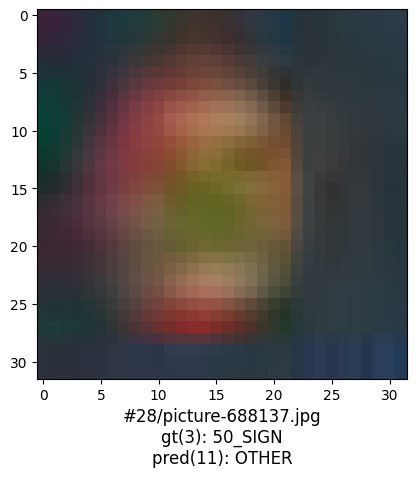

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=44
picture-863791.jpg gt=90_SIGN, pred=50_SIGN


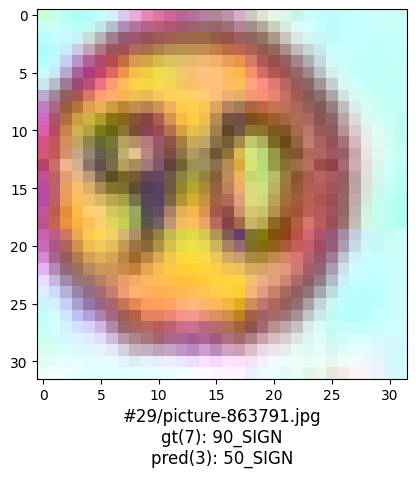

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-873273.jpg gt=PEDESTRIAN_CROSSING, pred=OTHER


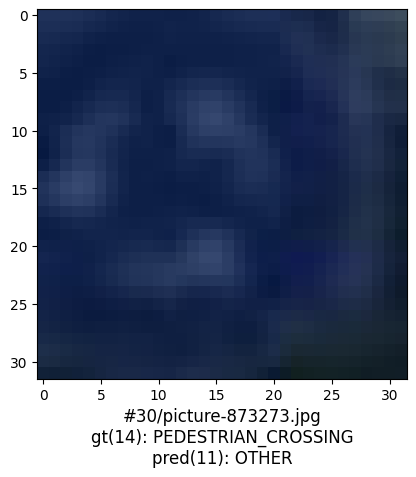

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=41
picture-263591.jpg gt=90_SIGN, pred=50_SIGN


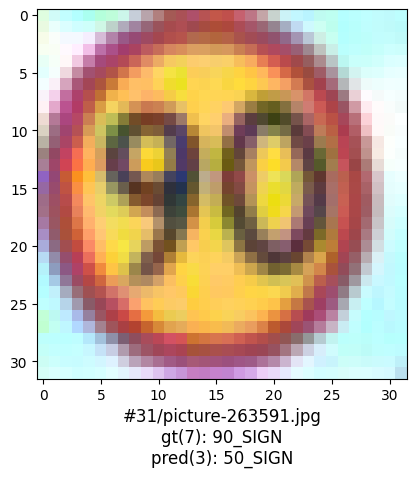

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-668220.jpg gt=60_SIGN, pred=50_SIGN


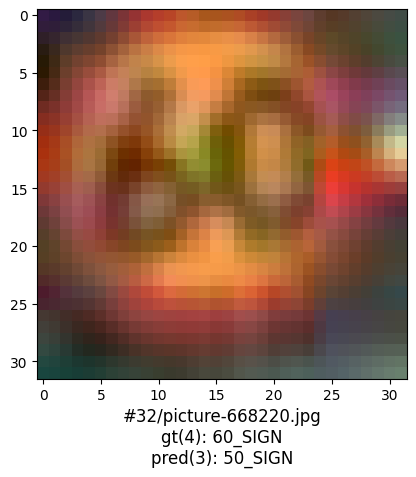

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-128355.jpg gt=PEDESTRIAN_CROSSING, pred=OTHER


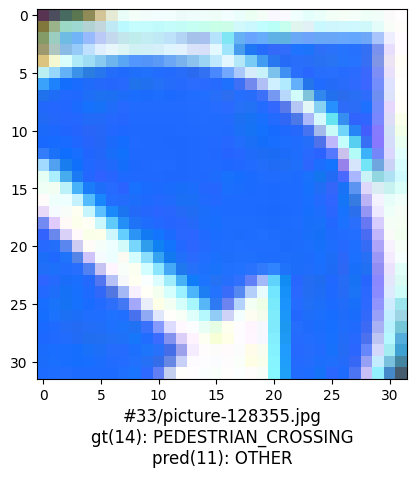

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=41
picture-441025.jpg gt=110_SIGN, pred=70_SIGN


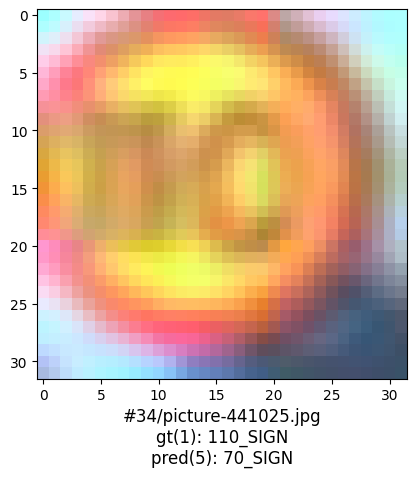

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-717296.jpg gt=110_SIGN, pred=70_SIGN


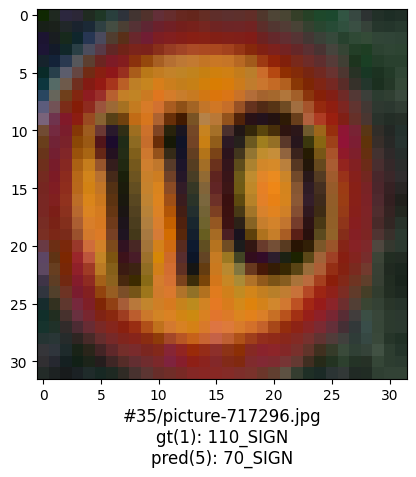

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-127135.jpg gt=110_SIGN, pred=70_SIGN


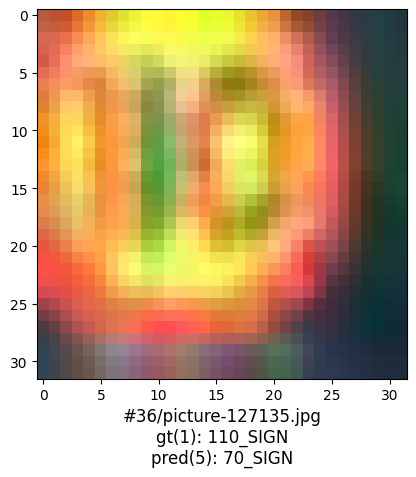

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=44
picture-439143.jpg gt=110_SIGN, pred=70_SIGN


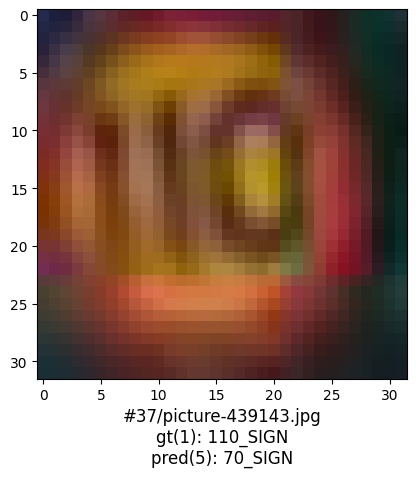

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-921084.jpg gt=30_SIGN, pred=50_SIGN


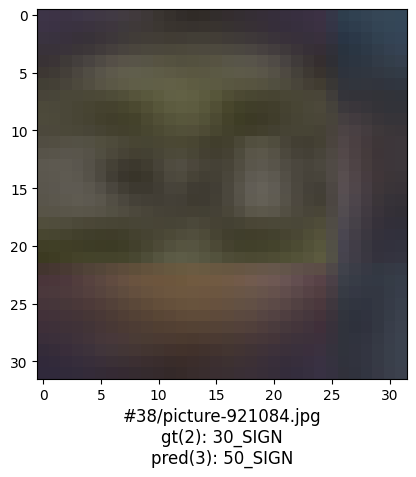

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-696386.jpg gt=60_SIGN, pred=GIVE_WAY


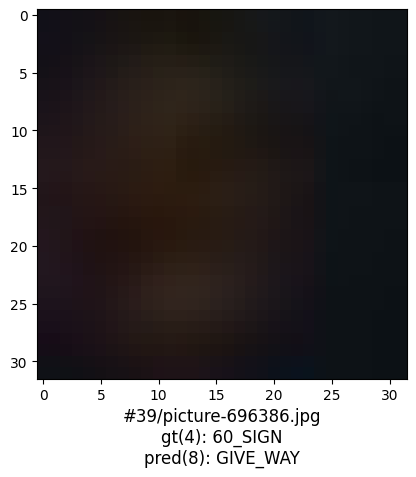

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=44
picture-646767.jpg gt=110_SIGN, pred=70_SIGN


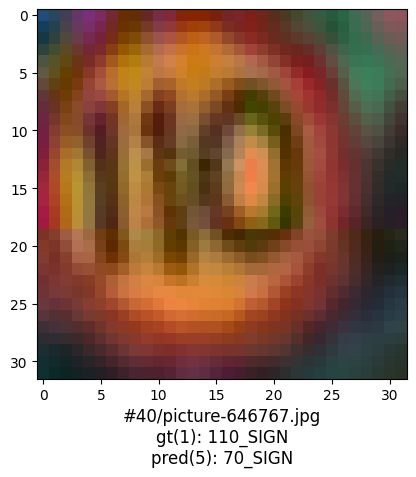

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-801780.jpg gt=90_SIGN, pred=70_SIGN


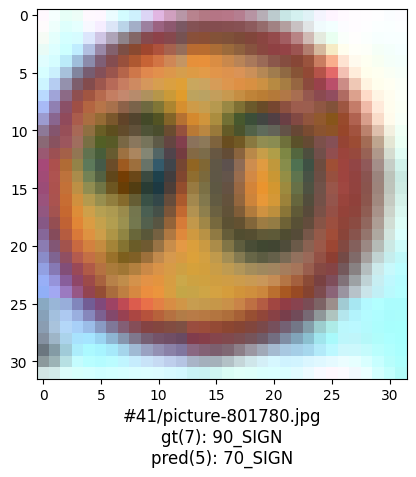

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-743438.jpg gt=PEDESTRIAN_CROSSING, pred=OTHER


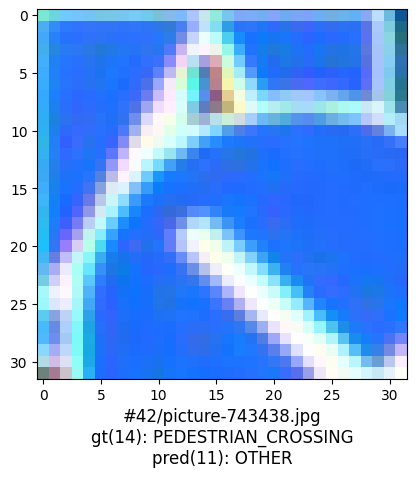

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=44
picture-104702.jpg gt=60_SIGN, pred=GIVE_WAY


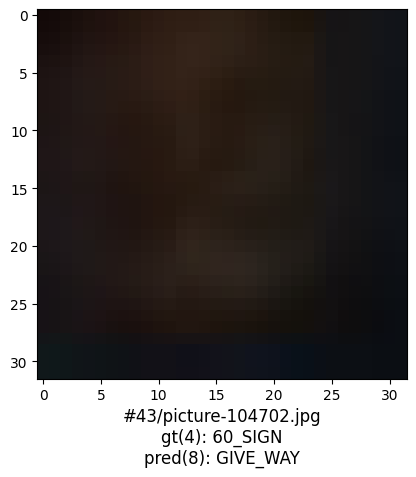

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=44
picture-940909.jpg gt=80_SIGN, pred=50_SIGN


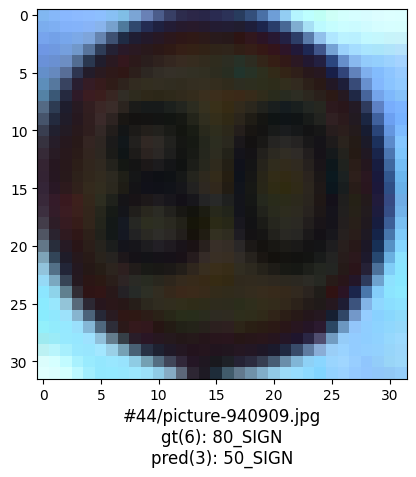

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-209604.jpg gt=30_SIGN, pred=70_SIGN


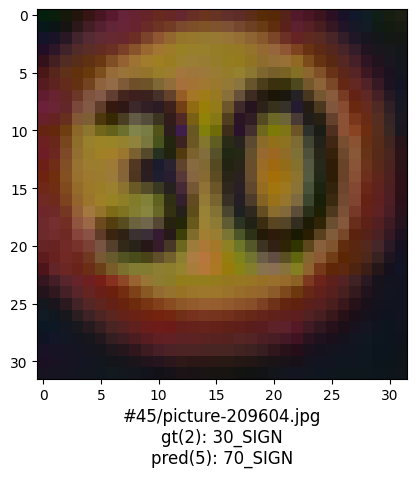

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-575954.jpg gt=90_SIGN, pred=70_SIGN


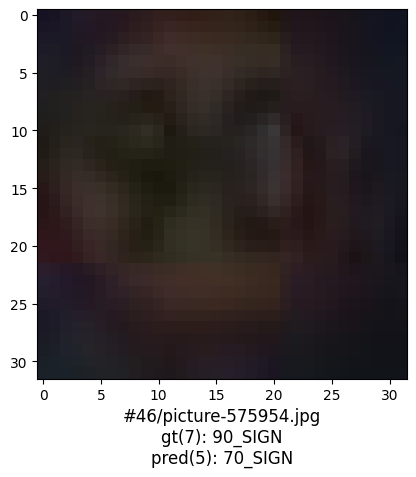

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-243645.jpg gt=30_SIGN, pred=70_SIGN


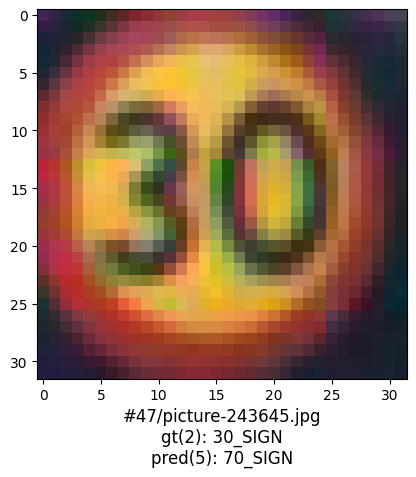

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-146699.jpg gt=90_SIGN, pred=70_SIGN


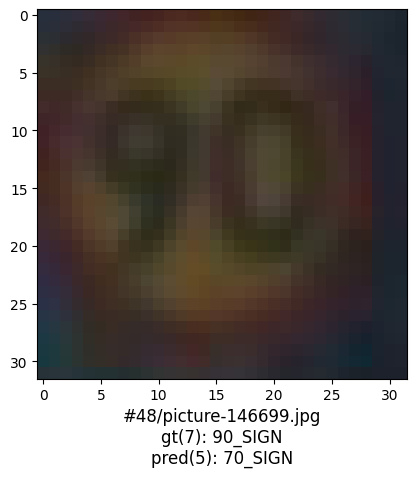

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-738820.jpg gt=80_SIGN, pred=70_SIGN


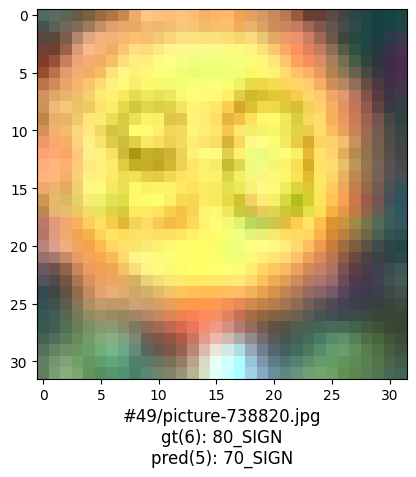

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-181020.jpg gt=110_SIGN, pred=50_SIGN


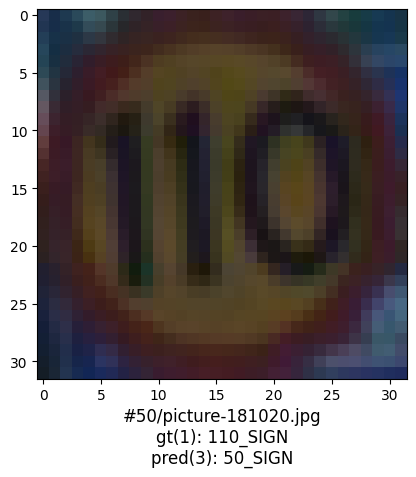

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-347922.jpg gt=90_SIGN, pred=50_SIGN


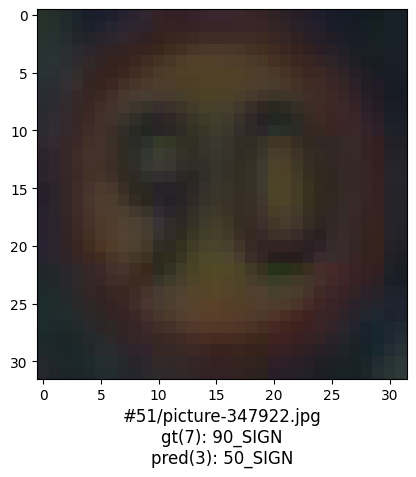

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-727323.jpg gt=60_SIGN, pred=50_SIGN


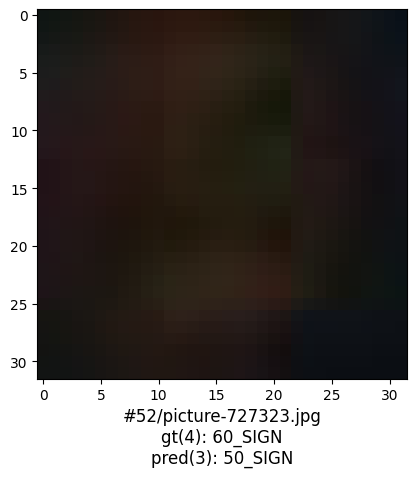

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=44
picture-330582.jpg gt=90_SIGN, pred=50_SIGN


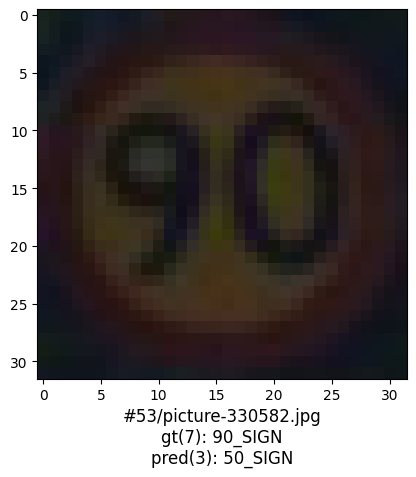

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-711244.jpg gt=110_SIGN, pred=70_SIGN


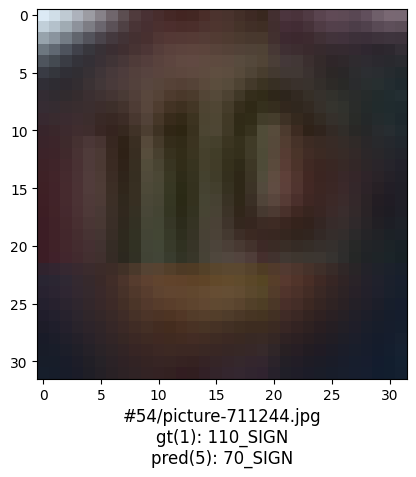

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-002470.jpg gt=90_SIGN, pred=50_SIGN


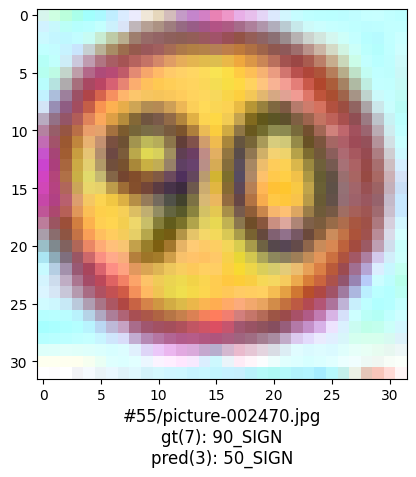

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-505119.jpg gt=90_SIGN, pred=70_SIGN


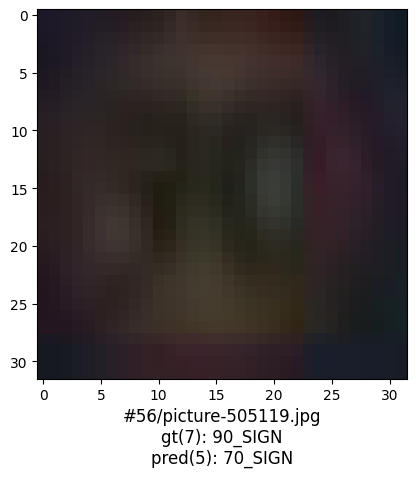

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-541229.jpg gt=60_SIGN, pred=50_SIGN


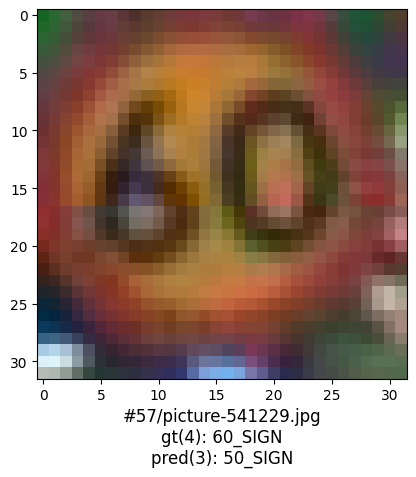

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-818008.jpg gt=30_SIGN, pred=70_SIGN


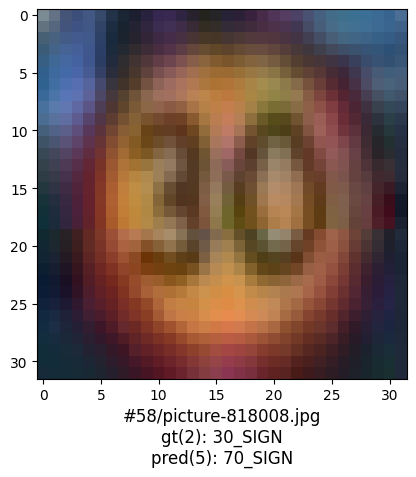

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-544996.jpg gt=90_SIGN, pred=70_SIGN


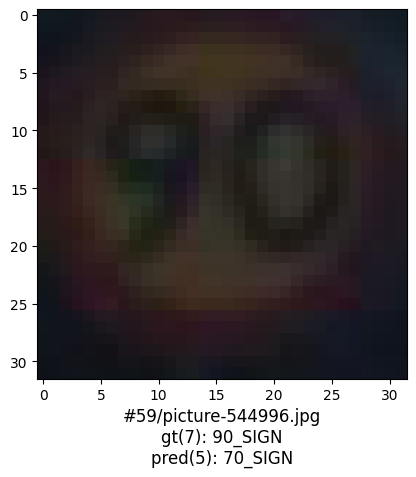

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-904380.jpg gt=30_SIGN, pred=OTHER


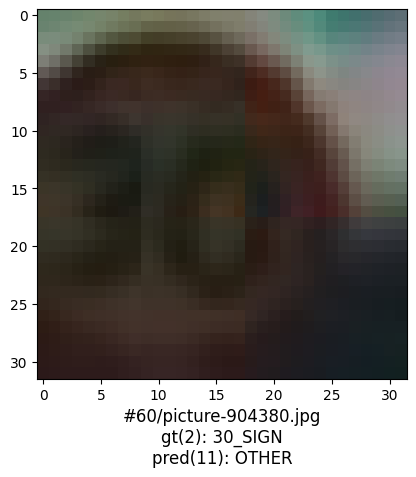

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-828594.jpg gt=110_SIGN, pred=70_SIGN


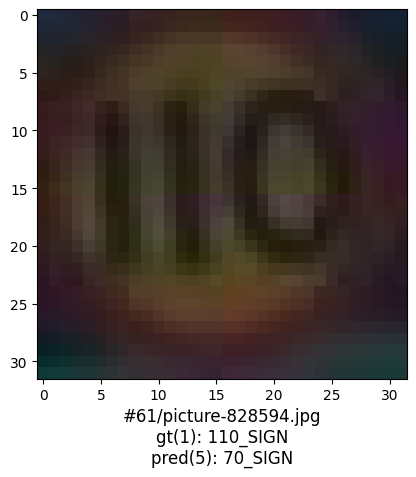

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-764244.jpg gt=60_SIGN, pred=50_SIGN


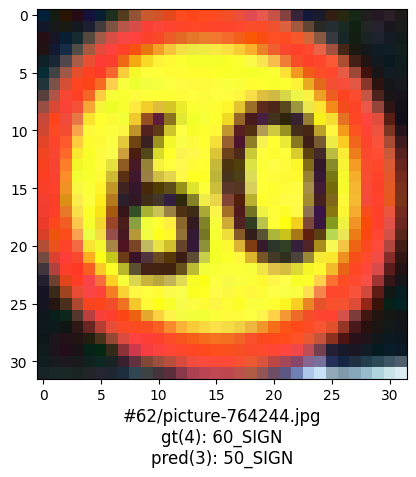

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-591487.jpg gt=PEDESTRIAN_CROSSING, pred=PASS_RIGHT_SIDE


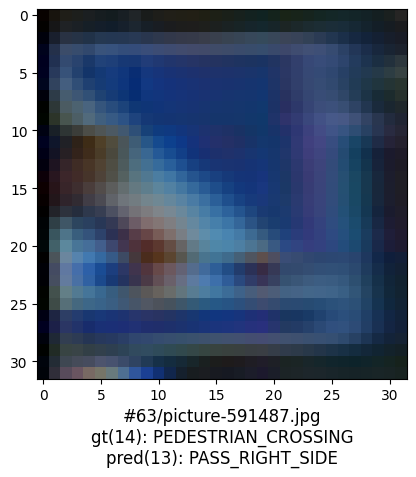

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-243149.jpg gt=60_SIGN, pred=80_SIGN


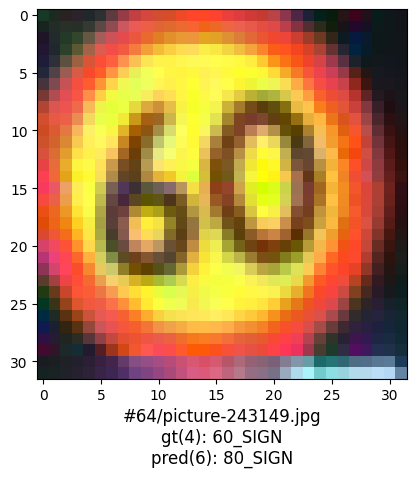

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-668402.jpg gt=OTHER, pred=GIVE_WAY


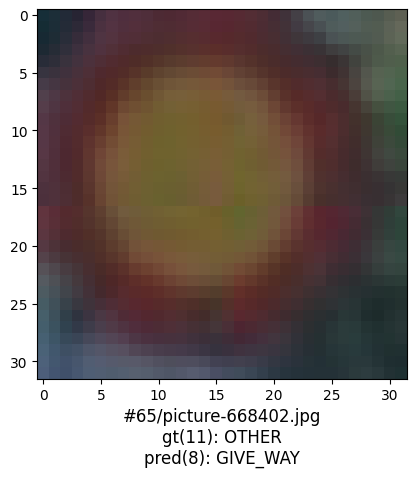

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-138943.jpg gt=110_SIGN, pred=50_SIGN


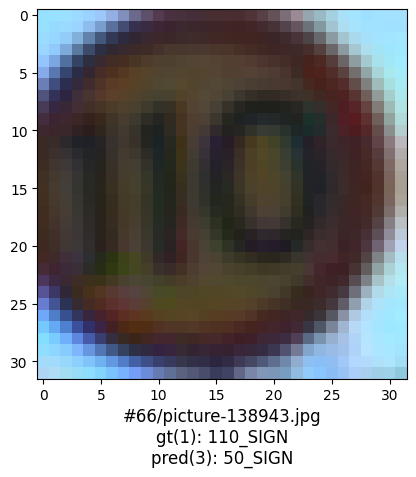

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-197602.jpg gt=80_SIGN, pred=50_SIGN


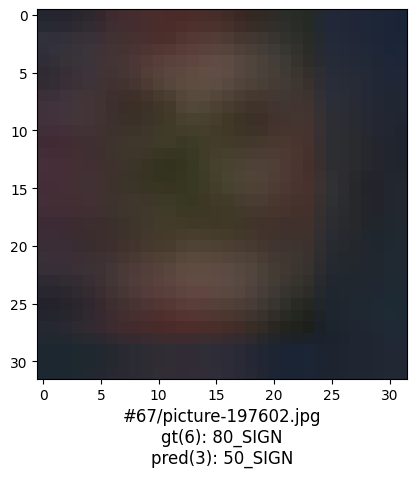

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=44
picture-127544.jpg gt=OTHER, pred=PEDESTRIAN_CROSSING


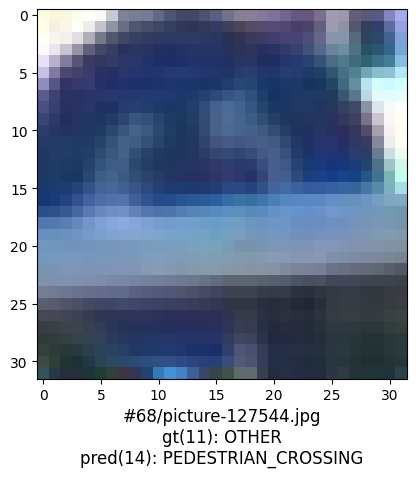

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-124748.jpg gt=110_SIGN, pred=70_SIGN


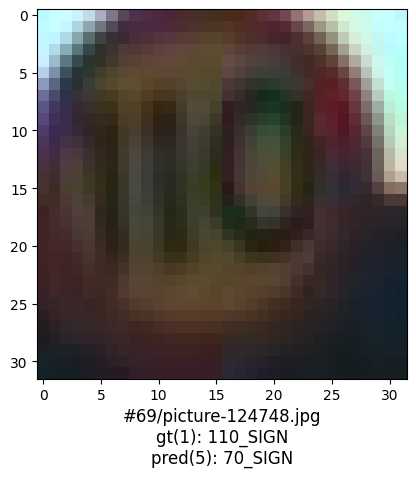

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-271810.jpg gt=60_SIGN, pred=80_SIGN


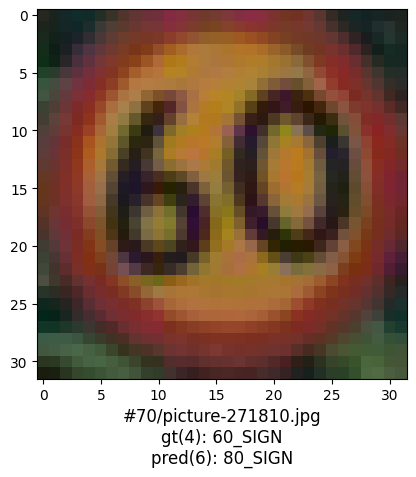

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-184363.jpg gt=PEDESTRIAN_CROSSING, pred=PASS_RIGHT_SIDE


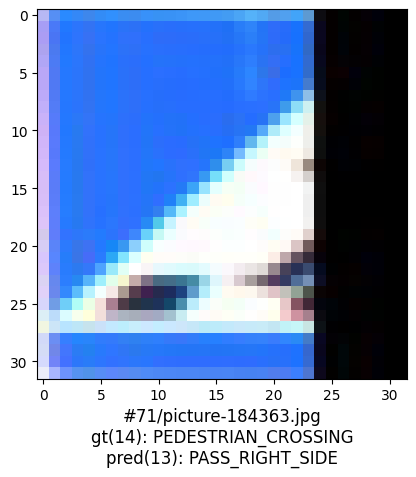

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-934186.jpg gt=110_SIGN, pred=70_SIGN


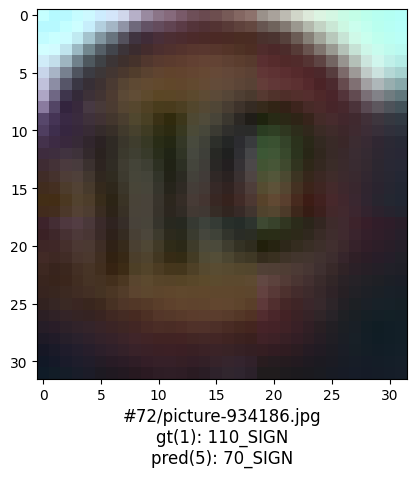

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-939570.jpg gt=110_SIGN, pred=70_SIGN


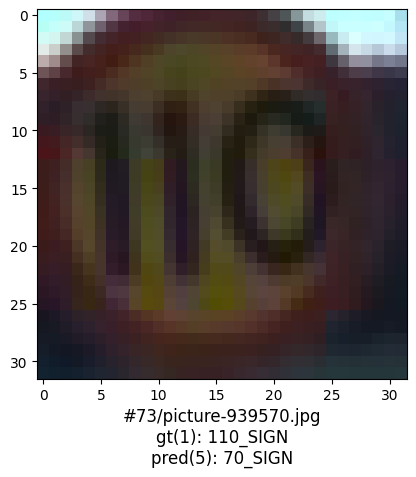

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-438583.jpg gt=110_SIGN, pred=70_SIGN


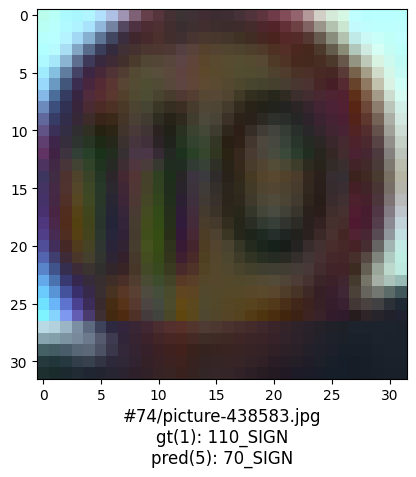

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-449913.jpg gt=90_SIGN, pred=50_SIGN


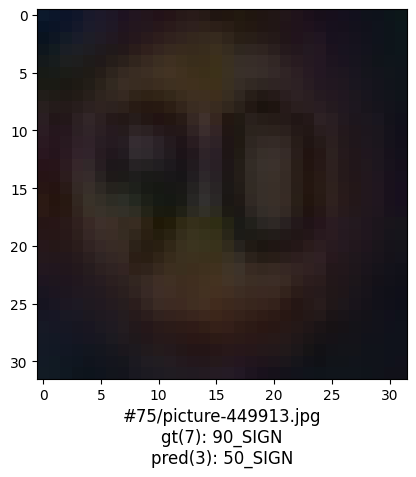

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-098219.jpg gt=GIVE_WAY, pred=50_SIGN


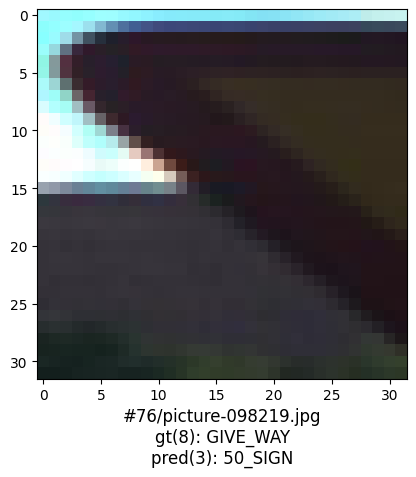

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-412612.jpg gt=PEDESTRIAN_CROSSING, pred=OTHER


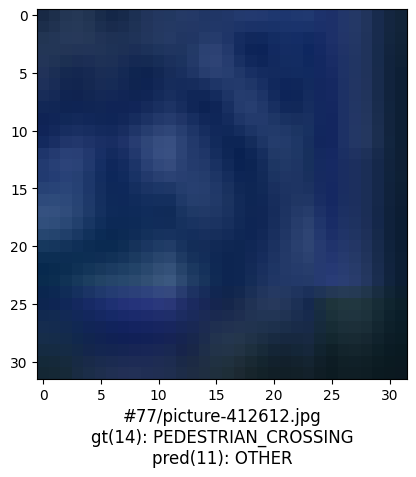

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=41
picture-033810.jpg gt=80_SIGN, pred=50_SIGN


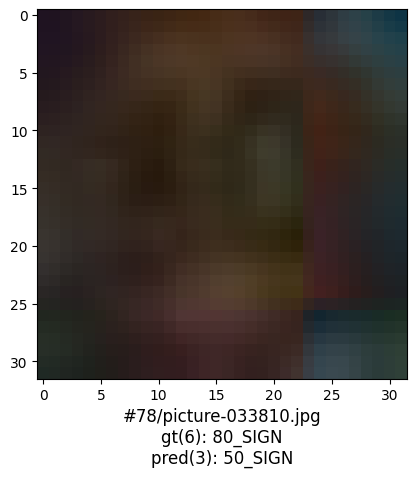

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=44
picture-734467.jpg gt=50_SIGN, pred=70_SIGN


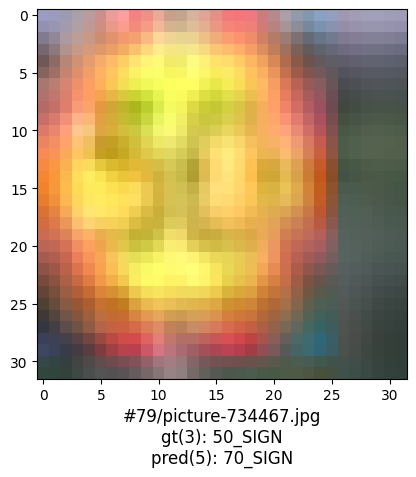

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-156100.jpg gt=60_SIGN, pred=50_SIGN


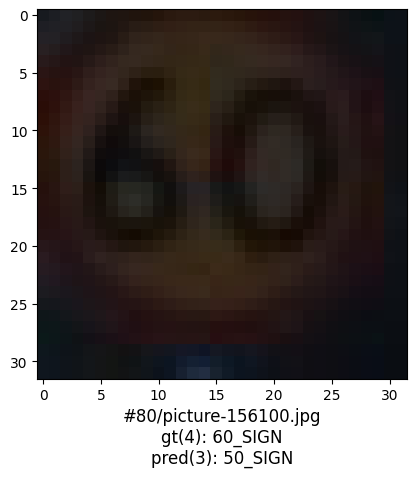

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-373177.jpg gt=60_SIGN, pred=50_SIGN


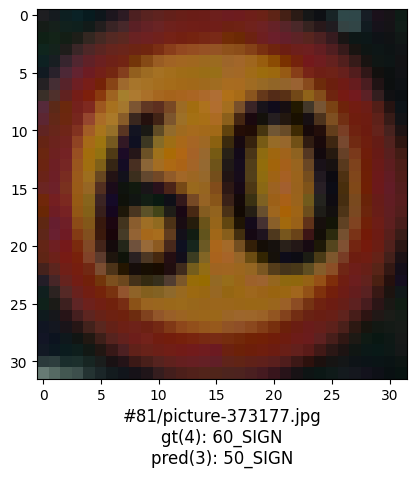

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-739931.jpg gt=OTHER, pred=GIVE_WAY


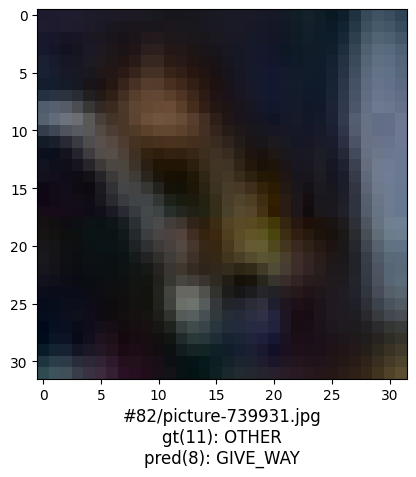

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=44
picture-918099.jpg gt=60_SIGN, pred=50_SIGN


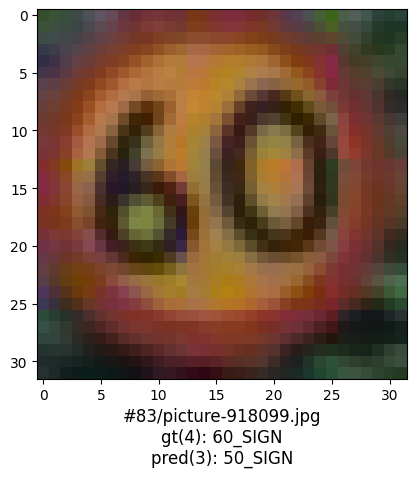

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-050115.jpg gt=90_SIGN, pred=50_SIGN


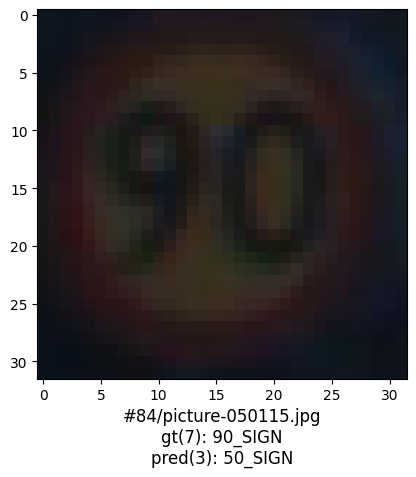

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-849513.jpg gt=60_SIGN, pred=50_SIGN


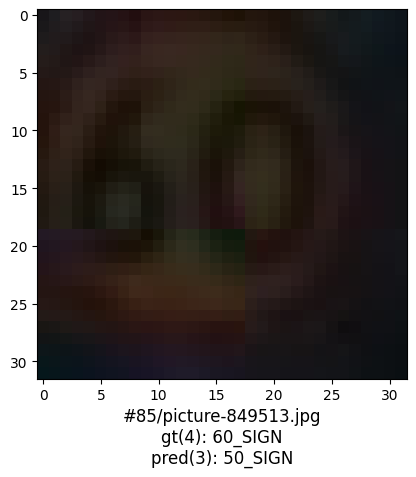

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-458733.jpg gt=60_SIGN, pred=50_SIGN


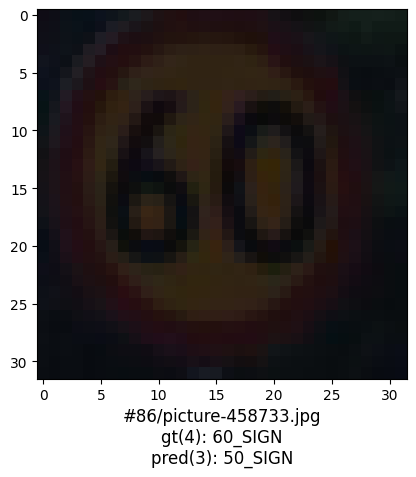

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-069528.jpg gt=30_SIGN, pred=70_SIGN


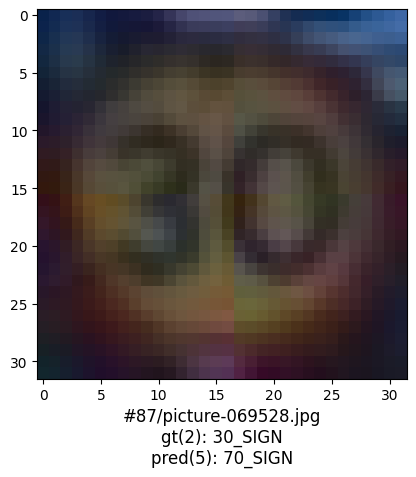

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-051379.jpg gt=50_SIGN, pred=PRIORITY_ROAD


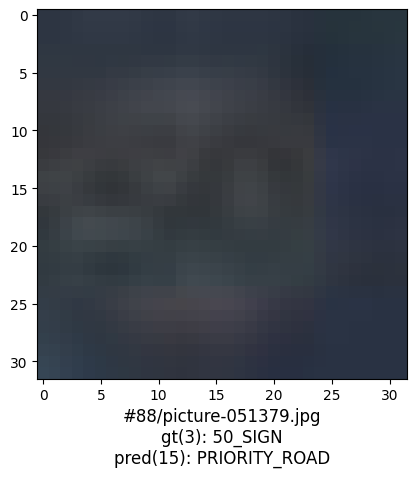

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=44
picture-616769.jpg gt=PEDESTRIAN_CROSSING, pred=OTHER


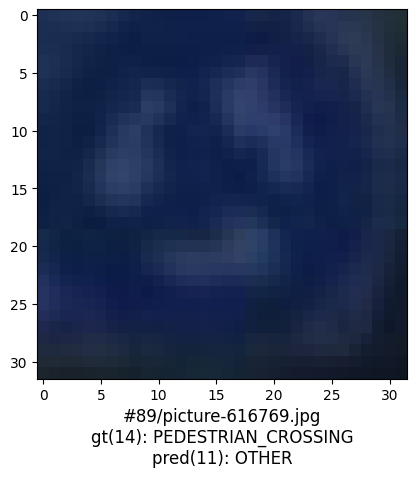

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=41
picture-238356.jpg gt=110_SIGN, pred=70_SIGN


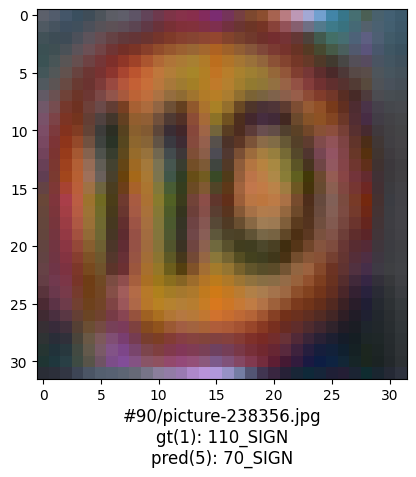

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-596894.jpg gt=80_SIGN, pred=50_SIGN


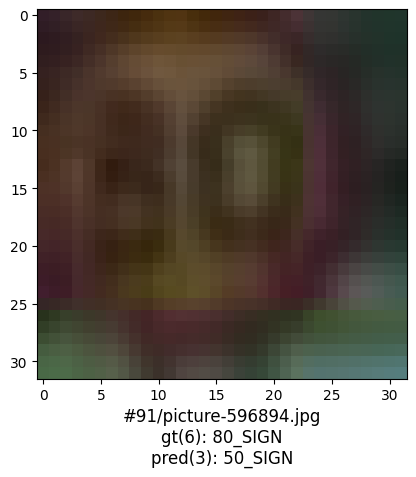

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=44
picture-760745.jpg gt=30_SIGN, pred=50_SIGN


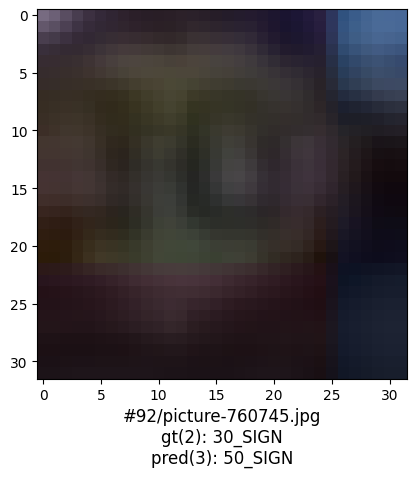

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=44
picture-705111.jpg gt=60_SIGN, pred=50_SIGN


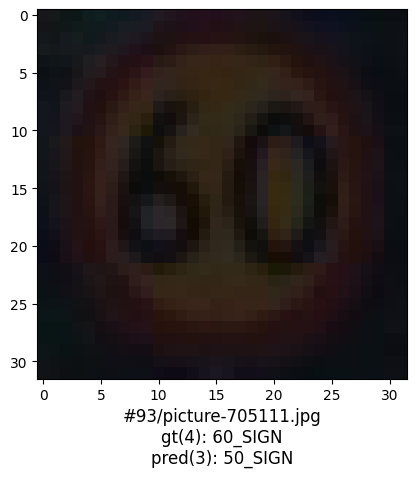

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-074857.jpg gt=80_SIGN, pred=50_SIGN


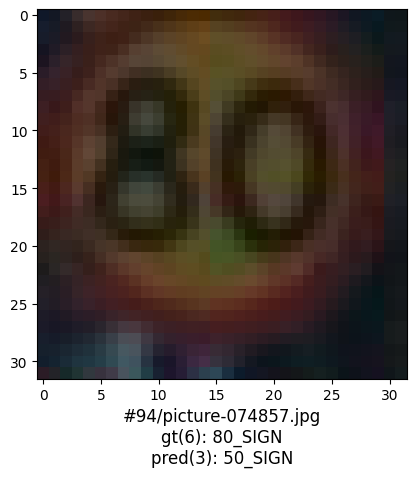

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-337649.jpg gt=OTHER, pred=NO_PARKING


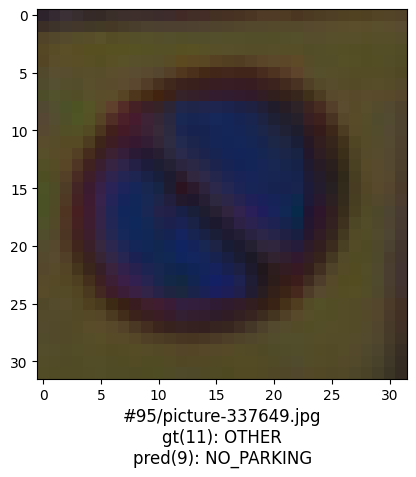

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=41
picture-822804.jpg gt=80_SIGN, pred=50_SIGN


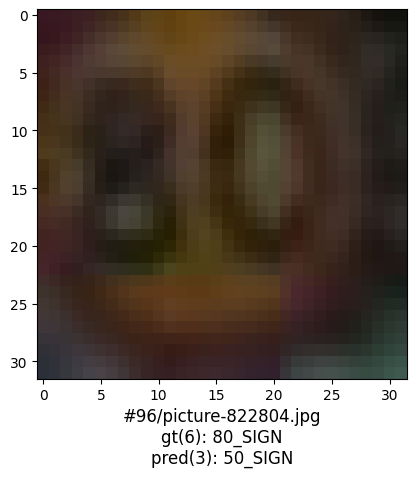

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-928575.jpg gt=30_SIGN, pred=50_SIGN


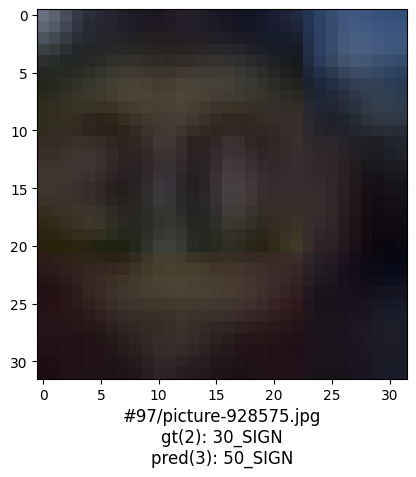

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-193654.jpg gt=30_SIGN, pred=50_SIGN


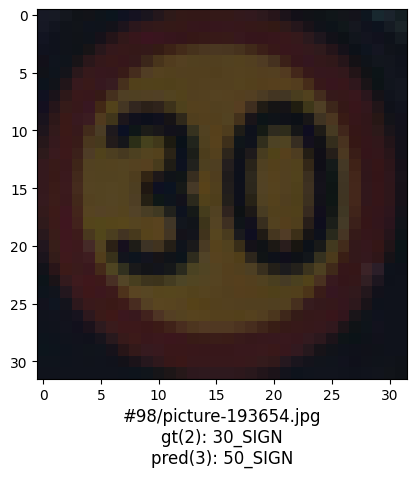

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-755531.jpg gt=70_SIGN, pred=OTHER


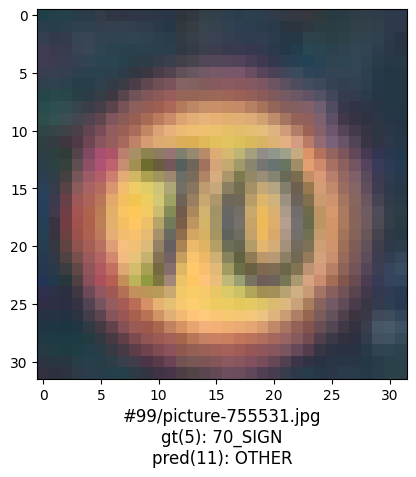

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-708409.jpg gt=30_SIGN, pred=50_SIGN


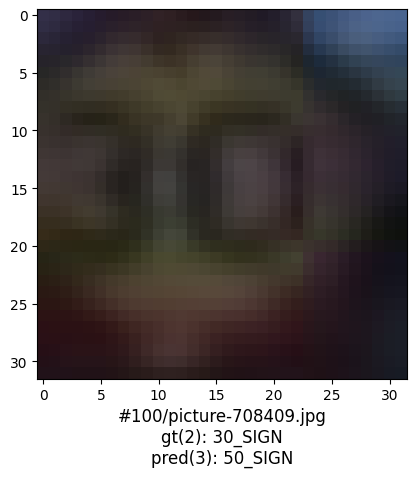

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-979586.jpg gt=80_SIGN, pred=50_SIGN


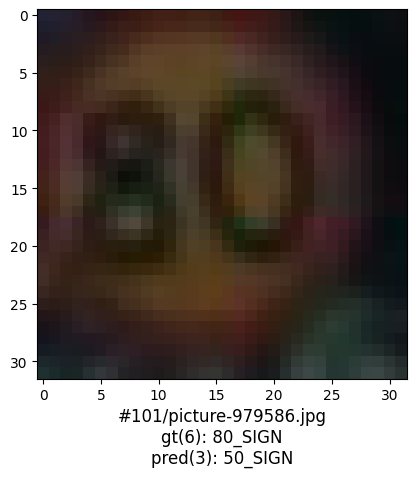

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-144280.jpg gt=50_SIGN, pred=70_SIGN


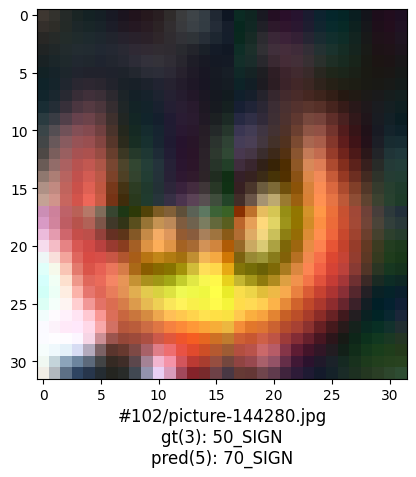

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=44
picture-072815.jpg gt=30_SIGN, pred=50_SIGN


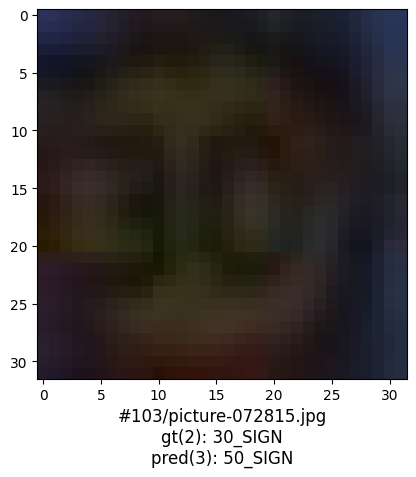

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-792528.jpg gt=30_SIGN, pred=50_SIGN


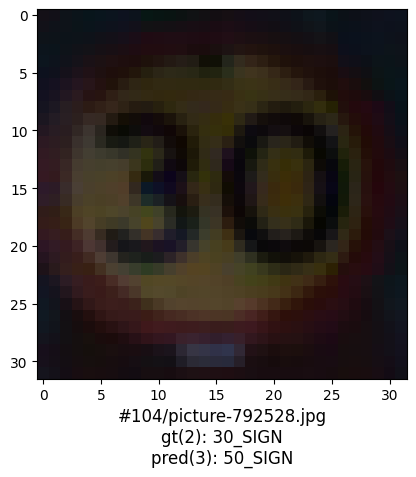

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-937793.jpg gt=30_SIGN, pred=50_SIGN


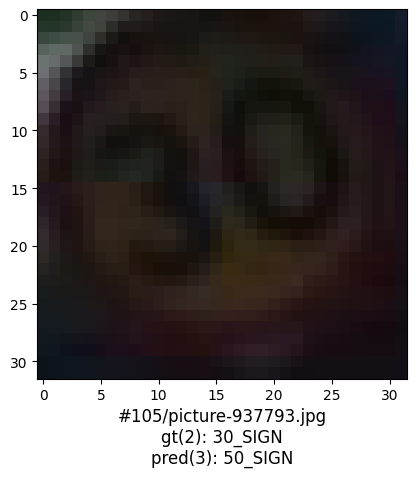

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-655022.jpg gt=30_SIGN, pred=70_SIGN


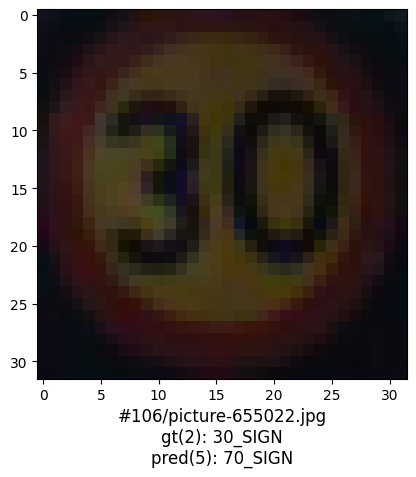

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-054031.jpg gt=50_SIGN, pred=PRIORITY_ROAD


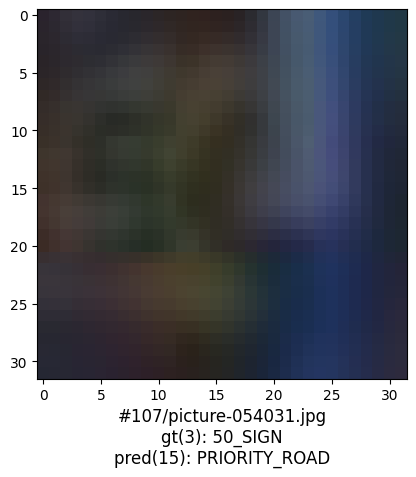

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42
picture-800118.jpg gt=30_SIGN, pred=50_SIGN


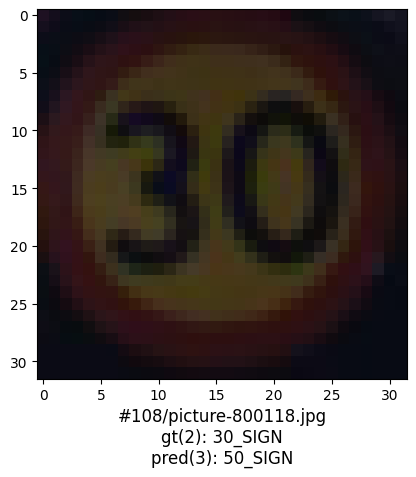

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-923949.jpg gt=30_SIGN, pred=50_SIGN


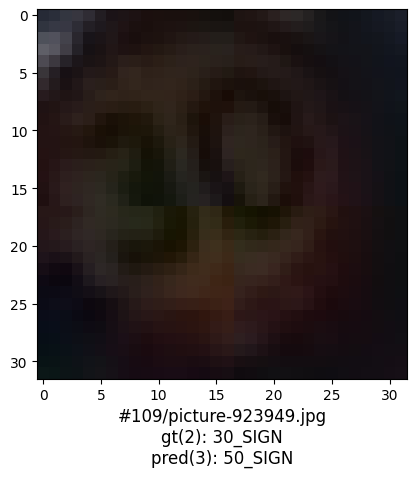

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-670541.jpg gt=30_SIGN, pred=50_SIGN


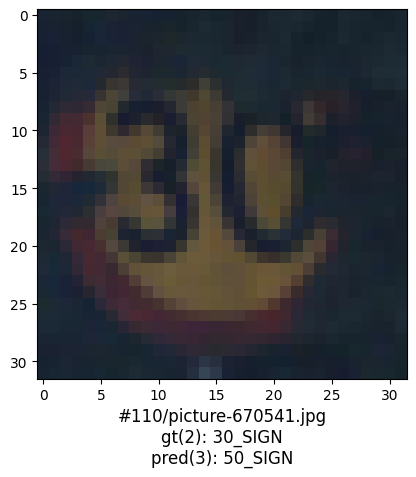

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-624972.jpg gt=50_SIGN, pred=70_SIGN


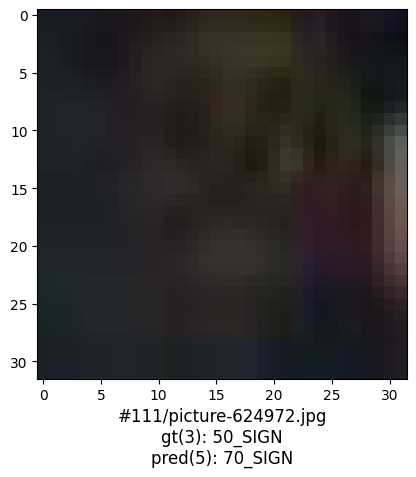

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=44
picture-875948.jpg gt=30_SIGN, pred=50_SIGN


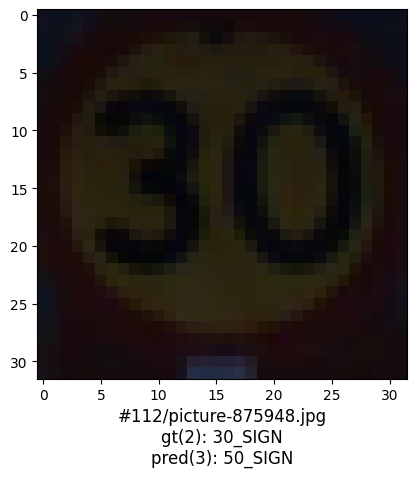

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=43
picture-678166.jpg gt=100_SIGN, pred=OTHER


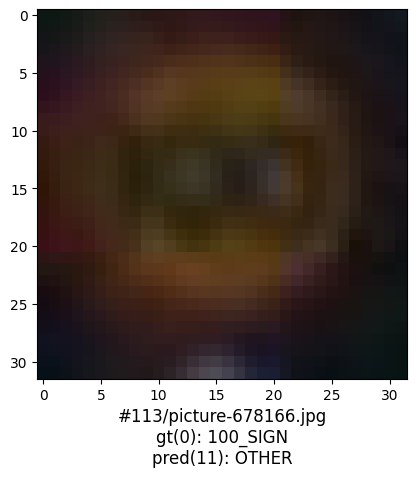

gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=42


In [25]:
def is_label_issue():
    is_issue = input("gt is incorrect=1, gt correct but ambiguous=2, gt is correct=3, ambiguous=4")
    if is_issue == "1":
        return 'gt correct'
    elif is_issue == "2":
        return 'gt correct but ambiguous'
    elif is_issue == "3":
        return 'gt incorrect'
    else:
        assert is_issue == "4"
        return 'ambiguous'



def prompt_img(img_indexes, df):
    print(f'Original len of rows ={len(df)}')

    # gt correct/gt correct but ambiguous/gt incorrect/ambiguous/not detected
    df = df.assign(is_issue='not detected')
    df_filtered = df[df['data_idxs'].isin(img_indexes)]
    print(f'filtered df len of rows ={len(df_filtered)}')
    
    counter = 0
    for index, row in df_filtered.iterrows():
        # print(row['imagenames'], row['c2'])
        image = Image.open(row['paths'])
        image = np.array(image.resize((32,32)))
        print(f"{row['imgnames']} gt={row['labels_gt_des']}, pred={row['labels_pred_des']}")
        counter += 1
        plt.title(f"#{counter}/{row['imgnames']}\ngt({row['labels_gt']}): {row['labels_gt_des']}\npred({row['labels_pred']}): {row['labels_pred_des']}", y=-0.25)
        plt.imshow(image)
        plt.pause(0.001)
        # is_issue = 
        df.at[row['data_idxs'],'is_issue'] = is_label_issue()
        # print(f'is_issue={is_issue}')
        plt.cla()
        plt.close()
        # if counter == 5:
        #     break
    
    return df


# probs	labels_gt	labels_gt_des	labels_pred	labels_pred_des	losses	paths	imgnames	data_idxs

CL_indexes = set(list(chain(*list(CL_label_issues.values()))))
lrank_indexes = set(list(chain(*list(lrank_label_issues.values()))))
# lrank_label_issues
all_indexes = CL_indexes | lrank_indexes
print(f'len of all_indexes={len(all_indexes)}, len of CL_indexes={len(CL_indexes)}, lrank_indexes={len(lrank_indexes)}')

df_labelissue = prompt_img(all_indexes, df_sorted)
# df_labelissue




In [26]:
df_path = f'{df_dir}/{figname}'
df_labelissue.to_csv(f'{df_path}_issue.csv')

In [27]:
health_summary(labels_gt, probs, class_names=classes_name)

-----------------------------------------------------------
|  Generating a Cleanlab Dataset Health Summary           |
|   for your dataset with 2,503 examples and 17 classes.  |
|  Note, Cleanlab is not a medical doctor... yet.         |
-----------------------------------------------------------

Overall Class Quality and Noise across your dataset (below)
------------------------------------------------------------ 



Class Name  Class Index  Label Issues  Inverse Label Issues  Label Noise  \
0            1            1            15                     8     0.833333   
1            7            7            13                    17     0.812500   
2            4            4            15                     3     0.789474   
3            2            2            19                    17     0.633333   
4            6            6            14                     8     0.229508   
5            3            3            20                    37     0.169492   
6            0            0             5                     0     0.080645   
7            5            5             8                    17     0.053333   
8           11           11             7                     4     0.021739   
9           14           14             3                     0     0.004762   
10          13           13             0                     0     0.000000   
11          12           12             0                     0     0.000000   
12           8            8             0                     2     0.000000   
13           9            9             0                     1     0.000000   
14          15           15             0                     5     0.000000   
15          10           10             0                     0     0.000000   
16          16           16             0                     0     0.000000   

    Inverse Label Noise  Label Quality Score  
0              0.727273             0.166667  
1              0.850000             0.187500  
2              0.428571             0.210526  
3              0.607143             0.366667  
4              0.145455             0.770492  
5              0.274074             0.830508  
6              0.000000             0.919355  
7              0.106918             0.946667  
8              0.012539             0.978261  
9              0.000000             0.995238  
10             0.000000             1.000000  
11             0.000000             1.000000  
12             0.013793             1.000000  
13             0.021739             1.000000  
14             0.011287             1.000000  
15             0.000000             1.000000  
16             0.000000             1.000000


Class Overlap. In some cases, you may want to merge classes in the top rows (below)
-----------------------------------------------------------------------------------



Class Name A   Class Name B  Class Index A  Class Index B  \
0          30_SIGN        50_SIGN              2              3   
1          50_SIGN        90_SIGN              3              7   
2         110_SIGN        70_SIGN              1              5   
3          50_SIGN        60_SIGN              3              4   
4          60_SIGN        80_SIGN              4              6   
..             ...            ...            ...            ...   
131        50_SIGN     NO_PARKING              3              9   
132        50_SIGN       GIVE_WAY              3              8   
133        30_SIGN           STOP              2             16   
134        30_SIGN  PRIORITY_ROAD              2             15   
135  PRIORITY_ROAD           STOP             15             16   

     Num Overlapping Examples  Joint Probability  
0                          23           0.009189  
1                          13           0.005194  
2                          11           0.004395  
3                           9           0.003596  
4                           8           0.003196  
..                        ...                ...  
131                         0           0.000000  
132                         0           0.000000  
133                         0           0.000000  
134                         0           0.000000  
135                         0           0.000000  

[136 rows x 6 columns]


 * Overall, about 5% (119 of the 2,503) labels in your dataset have potential issues.
 ** The overall label health score for this dataset is: 0.95.

Generated with <3 from Cleanlab.



{'overall_label_health_score': 0.9524570515381543,
 'joint': array([[0.02277267, 0.00119856, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.00079904, 0.        ],
        [0.        , 0.00119856, 0.00079904, 0.00079904, 0.        ,
         0.00439473, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.00039952, 0.00439473, 0.00639233, 0.        ,
         0.00079904, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.00039952, 0.00279664, 0.03915302, 0.        ,
         0.00039952, 0.00119856, 0.00279664, 0.        , 0.        ,
         0.        , 0.00039952, 0.        , 0.        , 0.        ,
         0

In [28]:
df_labelissue.head(10)

probs  labels_gt        labels_gt_des  labels_pred  labels_pred_des  \
916   0.998867          0             100_SIGN           15    PRIORITY_ROAD   
21    0.997117          5              70_SIGN           15    PRIORITY_ROAD   
31    0.997111          5              70_SIGN           15    PRIORITY_ROAD   
592   0.984032         11                OTHER            8         GIVE_WAY   
2378  0.677629          8             GIVE_WAY           11            OTHER   
1595  0.837451          3              50_SIGN           11            OTHER   
506   0.843133          2              30_SIGN            8         GIVE_WAY   
644   0.495999          5              70_SIGN           15    PRIORITY_ROAD   
331   0.888992          3              50_SIGN            8         GIVE_WAY   
2159  0.623874         14  PEDESTRIAN_CROSSING           13  PASS_RIGHT_SIDE   

            losses                                              paths  \
916  -1.894439e-07  ../datasets/sweden-traffic-signs-classificatio...   
21   -1.703039e-04  ../datasets/sweden-traffic-signs-classificatio...   
31   -2.838651e-04  ../datasets/sweden-traffic-signs-classificatio...   
592  -3.164462e-04  ../datasets/sweden-traffic-signs-classificatio...   
2378 -8.252159e-04  ../datasets/sweden-traffic-signs-classificatio...   
1595 -2.856319e-03  ../datasets/sweden-traffic-signs-classificatio...   
506  -3.928970e-03  ../datasets/sweden-traffic-signs-classificatio...   
644  -5.258515e-03  ../datasets/sweden-traffic-signs-classificatio...   
331  -7.844064e-03  ../datasets/sweden-traffic-signs-classificatio...   
2159 -8.861963e-03  ../datasets/sweden-traffic-signs-classificatio...   

                imgnames  data_idxs  PBNR_NMargin  PBNR_SConf  PBNR_CWE  \
916   picture-198148.jpg        916          True        True      True   
21    picture-936931.jpg         21          True        True      True   
31    picture-268671.jpg         31          True        True      True   
592   picture-543098.jpg        592          True        True      True   
2378  picture-086430.jpg       2378         False       False     False   
1595  picture-804010.jpg       1595          True        True      True   
506   picture-977262.jpg        506         False       False     False   
644   picture-556556.jpg        644          True        True      True   
331   picture-094669.jpg        331          True        True      True   
2159  picture-392086.jpg       2159         False       False     False   

      LRank                  is_issue  
916    True                gt correct  
21     True                gt correct  
31     True                gt correct  
592    True                 ambiguous  
2378   True  gt correct but ambiguous  
1595   True  gt correct but ambiguous  
506    True                 ambiguous  
644    True  gt correct but ambiguous  
331    True  gt correct but ambiguous  
2159   True                gt correct

In [29]:
#################### Baseline ####################
print('------------ Confusion issues ------------')

label_issues_confusion = find_predicted_neq_given(
    labels_gt,
    probs
)
labels_gt_issues_confusion = list(compress(range(len(labels_gt)), label_issues_confusion))
print(f"Cleanlab found {len(labels_gt_issues_confusion)} label issues.")

print('------------ Argmax issues ------------')
# A simple baseline approach that considers argmax(pred_probs) != labels as the examples with label issues.
label_issues_argmax = find_label_issues_using_argmax_confusion_matrix(
    labels_gt,
    probs
)
labels_gt_issues_argmax = list(compress(range(len(labels_gt)), label_issues_argmax))
print(f"Cleanlab found {len(labels_gt_issues_argmax)} label issues.")

------------ Confusion issues ------------
Cleanlab found 208 label issues.
------------ Argmax issues ------------
Cleanlab found 186 label issues.
